### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_2_0/'
summaries_path = cur_dir + 'summaries_2_0/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 2
    k = 0
    labels_list = list(range(num_class))
    seed = 0
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    while (k < num_class):
        split.append(labels_list[k : k + class_per_task])
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [11]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [12]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [13]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [14]:
t = 49
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams
    

In [15]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [16]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/8, validation accuracies: [0.5], average train loss: 2.387014, average train accuracy: 0.524414
epoch: 2, iter: 0/8, validation accuracies: [0.5], average train loss: 1.000477, average train accuracy: 0.527344
epoch: 3, iter: 0/8, validation accuracies: [0.55000001], average train loss: 0.743526, average train accuracy: 0.673828
epoch: 4, iter: 0/8, validation accuracies: [0.77499998], average train loss: 0.633906, average train accuracy: 0.704102
epoch: 5, iter: 0/8, validation accuracies: [0.69999999], average train loss: 0.567411, average train accuracy: 0.743164
epoch: 6, iter: 0/8, validation accuracies: [0.77499998], average train loss: 0.534775, average train accuracy: 0.753906
epoch: 7, iter: 0/8, validation accuracies: [0.82499999], average train loss: 0.558817, average train accuracy: 0.759766
epoch

epoch: 66, iter: 0/8, validation accuracies: [0.89999998], average train loss: 0.190020, average train accuracy: 0.917969
epoch: 67, iter: 0/8, validation accuracies: [0.89999998], average train loss: 0.201034, average train accuracy: 0.914062
epoch: 68, iter: 0/8, validation accuracies: [0.89999998], average train loss: 0.171345, average train accuracy: 0.938477
epoch: 69, iter: 0/8, validation accuracies: [0.89999998], average train loss: 0.185674, average train accuracy: 0.934570
epoch: 70, iter: 0/8, validation accuracies: [0.92500001], average train loss: 0.170505, average train accuracy: 0.936523
epochs: 70.000000, final train loss: 0.142273, validation accuracies: [0.92500001]
best epochs: 52.000000, best_avg: 0.975000, validation accuracies: [0.97500002]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0 at time step 560
calculating penultimate output...
time taken: %f 0.45268750190734863
sa

epoch: 49, iter: 0/8, validation accuracies: [0.75 0.75], average train loss: 0.673962, average train accuracy: 0.738281
epoch: 50, iter: 0/8, validation accuracies: [0.75       0.69999999], average train loss: 0.644974, average train accuracy: 0.749023
epoch: 50, iter: 0/8, loss: 0.653565, accuracy: 0.726562
epoch: 51, iter: 0/8, validation accuracies: [0.77499998 0.67500001], average train loss: 0.678995, average train accuracy: 0.726562
epoch: 52, iter: 0/8, validation accuracies: [0.72500002 0.77499998], average train loss: 0.666485, average train accuracy: 0.729492
epoch: 53, iter: 0/8, validation accuracies: [0.72500002 0.72500002], average train loss: 0.598938, average train accuracy: 0.753906
epoch: 54, iter: 0/8, validation accuracies: [0.72500002 0.77499998], average train loss: 0.635707, average train accuracy: 0.757812
epoch: 55, iter: 0/8, validation accuracies: [0.82499999 0.69999999], average train loss: 0.612033, average train accuracy: 0.756836
epoch: 56, iter: 0/8, va

epoch: 29, iter: 0/8, validation accuracies: [0.77499998 0.55000001 0.60000002], average train loss: 0.907540, average train accuracy: 0.662109
epoch: 30, iter: 0/8, validation accuracies: [0.75       0.52499998 0.57499999], average train loss: 0.862160, average train accuracy: 0.651367
epoch: 31, iter: 0/8, validation accuracies: [0.72500002 0.75       0.67500001], average train loss: 0.881689, average train accuracy: 0.658203
epoch: 32, iter: 0/8, validation accuracies: [0.77499998 0.625      0.64999998], average train loss: 0.842573, average train accuracy: 0.686523
epoch: 33, iter: 0/8, validation accuracies: [0.60000002 0.625      0.60000002], average train loss: 0.807253, average train accuracy: 0.672852
epoch: 34, iter: 0/8, validation accuracies: [0.77499998 0.69999999 0.42500001], average train loss: 0.862435, average train accuracy: 0.677734
epoch: 35, iter: 0/8, validation accuracies: [0.625      0.60000002 0.47499999], average train loss: 0.846952, average train accuracy: 0

epoch: 7, iter: 0/8, validation accuracies: [0.57499999 0.55000001 0.22499999 0.32499999], average train loss: 1.345964, average train accuracy: 0.505859
epoch: 8, iter: 0/8, validation accuracies: [0.57499999 0.42500001 0.57499999 0.47499999], average train loss: 1.376870, average train accuracy: 0.484375
epoch: 9, iter: 0/8, validation accuracies: [0.55000001 0.52499998 0.375      0.44999999], average train loss: 1.284459, average train accuracy: 0.555664
epoch: 10, iter: 0/8, validation accuracies: [0.625      0.15000001 0.47499999 0.69999999], average train loss: 1.348178, average train accuracy: 0.520508
epoch: 11, iter: 0/8, validation accuracies: [0.625      0.52499998 0.47499999 0.40000001], average train loss: 1.306931, average train accuracy: 0.540039
epoch: 12, iter: 0/8, validation accuracies: [0.625      0.42500001 0.60000002 0.625     ], average train loss: 1.212699, average train accuracy: 0.582031
epoch: 12, iter: 4/8, loss: 1.166644, accuracy: 0.554688
epoch: 13, iter:

epoch: 59, iter: 0/8, validation accuracies: [0.82499999 0.69999999 0.625      0.75      ], average train loss: 0.654966, average train accuracy: 0.750977
epoch: 60, iter: 0/8, validation accuracies: [0.77499998 0.69999999 0.57499999 0.64999998], average train loss: 0.667425, average train accuracy: 0.741211
epoch: 61, iter: 0/8, validation accuracies: [0.72500002 0.72500002 0.67500001 0.72500002], average train loss: 0.676902, average train accuracy: 0.750977
epoch: 62, iter: 0/8, validation accuracies: [0.69999999 0.72500002 0.67500001 0.75      ], average train loss: 0.721270, average train accuracy: 0.745117
epoch: 62, iter: 4/8, loss: 0.575870, accuracy: 0.765625
epoch: 63, iter: 0/8, validation accuracies: [0.69999999 0.75       0.64999998 0.69999999], average train loss: 0.650474, average train accuracy: 0.755859
epoch: 64, iter: 0/8, validation accuracies: [0.77499998 0.75       0.67500001 0.69999999], average train loss: 0.625381, average train accuracy: 0.766602
epoch: 65, it

epoch: 32, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.64999998 0.47499999 0.72500002], average train loss: 0.940067, average train accuracy: 0.699219
epoch: 33, iter: 0/8, validation accuracies: [0.5        0.42500001 0.625      0.67500001 0.75      ], average train loss: 0.971342, average train accuracy: 0.697266
epoch: 34, iter: 0/8, validation accuracies: [0.77499998 0.60000002 0.55000001 0.60000002 0.75      ], average train loss: 0.931008, average train accuracy: 0.684570
epoch: 35, iter: 0/8, validation accuracies: [0.72500002 0.64999998 0.75       0.34999999 0.85000002], average train loss: 0.942956, average train accuracy: 0.658203
epoch: 36, iter: 0/8, validation accuracies: [0.75       0.67500001 0.44999999 0.625      0.64999998], average train loss: 0.910954, average train accuracy: 0.705078
epoch: 37, iter: 0/8, validation accuracies: [0.64999998 0.375      0.67500001 0.52499998 0.69999999], average train loss: 0.967107, average train accuracy: 0.700195
epoc

epoch: 3, iter: 0/8, validation accuracies: [0.625      0.52499998 0.27500001 0.40000001 0.2        0.60000002], average train loss: 1.790262, average train accuracy: 0.483398
epoch: 4, iter: 0/8, validation accuracies: [0.47499999 0.34999999 0.47499999 0.27500001 0.175      0.64999998], average train loss: 1.758521, average train accuracy: 0.521484
epoch: 5, iter: 0/8, validation accuracies: [0.52499998 0.22499999 0.40000001 0.44999999 0.32499999 0.69999999], average train loss: 1.583490, average train accuracy: 0.550781
epoch: 6, iter: 0/8, validation accuracies: [0.5        0.5        0.32499999 0.42500001 0.40000001 0.57499999], average train loss: 1.571587, average train accuracy: 0.537109
epoch: 7, iter: 0/8, validation accuracies: [0.52499998 0.375      0.375      0.60000002 0.40000001 0.60000002], average train loss: 1.547457, average train accuracy: 0.541016
epoch: 8, iter: 0/8, validation accuracies: [0.57499999 0.47499999 0.34999999 0.55000001 0.52499998 0.67500001], average

epoch: 49, iter: 0/8, validation accuracies: [0.625      0.57499999 0.67500001 0.60000002 0.625      0.67500001], average train loss: 0.920204, average train accuracy: 0.723633
epoch: 50, iter: 0/8, validation accuracies: [0.67500001 0.69999999 0.64999998 0.64999998 0.69999999 0.69999999], average train loss: 0.865466, average train accuracy: 0.737305
epoch: 50, iter: 0/8, loss: 0.813998, accuracy: 0.734375
epoch: 51, iter: 0/8, validation accuracies: [0.67500001 0.625      0.64999998 0.67500001 0.72500002 0.67500001], average train loss: 0.802783, average train accuracy: 0.758789
epoch: 52, iter: 0/8, validation accuracies: [0.69999999 0.625      0.625      0.69999999 0.80000001 0.69999999], average train loss: 0.824465, average train accuracy: 0.779297
epoch: 53, iter: 0/8, validation accuracies: [0.69999999 0.625      0.67500001 0.625      0.85000002 0.64999998], average train loss: 0.750918, average train accuracy: 0.769531
epoch: 54, iter: 0/8, validation accuracies: [0.72500002 0

epoch: 17, iter: 0/8, validation accuracies: [0.52499998 0.52499998 0.57499999 0.47499999 0.55000001 0.85000002
 0.44999999], average train loss: 1.196577, average train accuracy: 0.588867
epoch: 18, iter: 0/8, validation accuracies: [0.40000001 0.55000001 0.69999999 0.44999999 0.64999998 0.42500001
 0.52499998], average train loss: 1.296625, average train accuracy: 0.553711
epoch: 19, iter: 0/8, validation accuracies: [0.5        0.47499999 0.47499999 0.52499998 0.60000002 0.625
 0.47499999], average train loss: 1.255989, average train accuracy: 0.555664
epoch: 20, iter: 0/8, validation accuracies: [0.55000001 0.52499998 0.40000001 0.57499999 0.57499999 0.69999999
 0.5       ], average train loss: 1.135503, average train accuracy: 0.598633
epoch: 21, iter: 0/8, validation accuracies: [0.67500001 0.64999998 0.60000002 0.375      0.60000002 0.77499998
 0.30000001], average train loss: 1.175539, average train accuracy: 0.574219
epoch: 22, iter: 0/8, validation accuracies: [0.55000001 0.3

epoch: 60, iter: 0/8, validation accuracies: [0.69999999 0.625      0.67500001 0.67500001 0.75       0.72500002
 0.72500002], average train loss: 0.760737, average train accuracy: 0.719727
epoch: 61, iter: 0/8, validation accuracies: [0.72500002 0.625      0.67500001 0.64999998 0.75       0.72500002
 0.69999999], average train loss: 0.763044, average train accuracy: 0.726562
epoch: 62, iter: 0/8, validation accuracies: [0.75       0.69999999 0.625      0.625      0.75       0.72500002
 0.67500001], average train loss: 0.687380, average train accuracy: 0.744141
epoch: 62, iter: 4/8, loss: 0.803338, accuracy: 0.765625
epoch: 63, iter: 0/8, validation accuracies: [0.67500001 0.69999999 0.60000002 0.67500001 0.72500002 0.72500002
 0.67500001], average train loss: 0.715519, average train accuracy: 0.764648
epoch: 64, iter: 0/8, validation accuracies: [0.67500001 0.67500001 0.57499999 0.67500001 0.72500002 0.69999999
 0.67500001], average train loss: 0.721504, average train accuracy: 0.75000

epoch: 25, iter: 0/8, validation accuracies: [0.42500001 0.5        0.69999999 0.55000001 0.72500002 0.72500002
 0.52499998 0.30000001], average train loss: 1.046778, average train accuracy: 0.547852
epoch: 25, iter: 0/8, loss: 0.899242, accuracy: 0.585938
epoch: 26, iter: 0/8, validation accuracies: [0.40000001 0.57499999 0.55000001 0.69999999 0.55000001 0.625
 0.55000001 0.5       ], average train loss: 1.075322, average train accuracy: 0.571289
epoch: 27, iter: 0/8, validation accuracies: [0.75       0.80000001 0.67500001 0.32499999 0.5        0.25
 0.375      0.52499998], average train loss: 1.156644, average train accuracy: 0.550781
epoch: 28, iter: 0/8, validation accuracies: [0.1        0.15000001 0.60000002 0.625      0.47499999 0.75
 0.34999999 0.40000001], average train loss: 1.302401, average train accuracy: 0.521484
epoch: 29, iter: 0/8, validation accuracies: [0.52499998 0.60000002 0.64999998 0.47499999 0.47499999 0.375
 0.60000002 0.44999999], average train loss: 1.228810

epoch: 66, iter: 0/8, validation accuracies: [0.67500001 0.72500002 0.69999999 0.64999998 0.69999999 0.625
 0.67500001 0.60000002], average train loss: 0.855756, average train accuracy: 0.677734
epoch: 67, iter: 0/8, validation accuracies: [0.69999999 0.75       0.72500002 0.64999998 0.69999999 0.64999998
 0.64999998 0.57499999], average train loss: 0.831419, average train accuracy: 0.654297
epoch: 68, iter: 0/8, validation accuracies: [0.69999999 0.77499998 0.72500002 0.64999998 0.69999999 0.67500001
 0.64999998 0.55000001], average train loss: 0.836210, average train accuracy: 0.650391
epoch: 69, iter: 0/8, validation accuracies: [0.69999999 0.82499999 0.69999999 0.69999999 0.69999999 0.69999999
 0.67500001 0.55000001], average train loss: 0.815524, average train accuracy: 0.672852
epoch: 70, iter: 0/8, validation accuracies: [0.69999999 0.82499999 0.67500001 0.69999999 0.69999999 0.64999998
 0.67500001 0.57499999], average train loss: 0.788576, average train accuracy: 0.666016
epoch

epoch: 29, iter: 0/8, validation accuracies: [0.67500001 0.67500001 0.40000001 0.25       0.60000002 0.72500002
 0.34999999 0.625      0.625     ], average train loss: 1.158933, average train accuracy: 0.543945
epoch: 30, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.40000001 0.75       0.625      0.75
 0.44999999 0.25       0.75      ], average train loss: 1.254111, average train accuracy: 0.600586
epoch: 31, iter: 0/8, validation accuracies: [0.47499999 0.44999999 0.5        0.52499998 0.55000001 0.80000001
 0.69999999 0.44999999 0.44999999], average train loss: 1.155674, average train accuracy: 0.604492
epoch: 32, iter: 0/8, validation accuracies: [0.69999999 0.52499998 0.55000001 0.42500001 0.625      0.75
 0.60000002 0.5        0.55000001], average train loss: 1.114818, average train accuracy: 0.600586
epoch: 33, iter: 0/8, validation accuracies: [0.625      0.40000001 0.67500001 0.67500001 0.55000001 0.64999998
 0.75       0.40000001 0.60000002], average train loss: 

epoch: 68, iter: 0/8, validation accuracies: [0.69999999 0.69999999 0.72500002 0.625      0.75       0.75
 0.72500002 0.57499999 0.67500001], average train loss: 0.927581, average train accuracy: 0.681641
epoch: 69, iter: 0/8, validation accuracies: [0.69999999 0.67500001 0.69999999 0.64999998 0.72500002 0.72500002
 0.72500002 0.57499999 0.67500001], average train loss: 0.811306, average train accuracy: 0.712891
epoch: 70, iter: 0/8, validation accuracies: [0.69999999 0.69999999 0.77499998 0.67500001 0.72500002 0.72500002
 0.72500002 0.60000002 0.67500001], average train loss: 0.850634, average train accuracy: 0.710938
epochs: 70.000000, final train loss: 0.785829, validation accuracies: [0.69999999 0.69999999 0.77499998 0.67500001 0.72500002 0.72500002
 0.72500002 0.60000002 0.67500001]
best epochs: 70.000000, best_avg: 0.700000, validation accuracies: [0.69999999 0.69999999 0.77499998 0.67500001 0.72500002 0.72500002
 0.72500002 0.60000002 0.67500001]
saving model dropout_hidden_prob

epoch: 29, iter: 0/8, validation accuracies: [0.47499999 0.625      0.44999999 0.5        0.375      0.44999999
 0.64999998 0.30000001 0.52499998 0.55000001], average train loss: 1.130160, average train accuracy: 0.674805
epoch: 30, iter: 0/8, validation accuracies: [0.60000002 0.55000001 0.52499998 0.5        0.5        0.69999999
 0.44999999 0.44999999 0.34999999 0.69999999], average train loss: 1.145979, average train accuracy: 0.638672
epoch: 31, iter: 0/8, validation accuracies: [0.64999998 0.64999998 0.625      0.625      0.5        0.75
 0.27500001 0.27500001 0.625      0.55000001], average train loss: 1.060582, average train accuracy: 0.651367
epoch: 32, iter: 0/8, validation accuracies: [0.375      0.67500001 0.375      0.625      0.52499998 0.44999999
 0.55000001 0.42500001 0.375      0.55000001], average train loss: 1.202101, average train accuracy: 0.646484
epoch: 33, iter: 0/8, validation accuracies: [0.55000001 0.5        0.60000002 0.5        0.55000001 0.67500001
 0.625

epoch: 66, iter: 0/8, validation accuracies: [0.72500002 0.75       0.60000002 0.625      0.69999999 0.72500002
 0.67500001 0.42500001 0.64999998 0.69999999], average train loss: 0.752694, average train accuracy: 0.771484
epoch: 67, iter: 0/8, validation accuracies: [0.72500002 0.77499998 0.60000002 0.625      0.69999999 0.72500002
 0.67500001 0.42500001 0.64999998 0.69999999], average train loss: 0.834133, average train accuracy: 0.744141
epoch: 68, iter: 0/8, validation accuracies: [0.69999999 0.80000001 0.625      0.64999998 0.69999999 0.72500002
 0.67500001 0.42500001 0.64999998 0.69999999], average train loss: 0.803718, average train accuracy: 0.744141
epoch: 69, iter: 0/8, validation accuracies: [0.72500002 0.75       0.60000002 0.64999998 0.69999999 0.72500002
 0.67500001 0.42500001 0.64999998 0.69999999], average train loss: 0.756546, average train accuracy: 0.759766
epoch: 70, iter: 0/8, validation accuracies: [0.72500002 0.80000001 0.60000002 0.67500001 0.69999999 0.75
 0.675

epoch: 26, iter: 0/8, validation accuracies: [0.57499999 0.55000001 0.47499999 0.42500001 0.60000002 0.64999998
 0.5        0.40000001 0.60000002 0.57499999 0.69999999], average train loss: 1.125888, average train accuracy: 0.626953
epoch: 27, iter: 0/8, validation accuracies: [0.60000002 0.57499999 0.75       0.60000002 0.69999999 0.52499998
 0.32499999 0.22499999 0.64999998 0.77499998 0.64999998], average train loss: 1.134327, average train accuracy: 0.647461
epoch: 28, iter: 0/8, validation accuracies: [0.60000002 0.60000002 0.52499998 0.625      0.75       0.47499999
 0.60000002 0.22499999 0.5        0.625      0.77499998], average train loss: 1.077012, average train accuracy: 0.627930
epoch: 29, iter: 0/8, validation accuracies: [0.32499999 0.60000002 0.52499998 0.375      0.60000002 0.57499999
 0.5        0.52499998 0.72500002 0.40000001 0.60000002], average train loss: 1.091568, average train accuracy: 0.660156
epoch: 30, iter: 0/8, validation accuracies: [0.30000001 0.60000002 

epoch: 61, iter: 0/8, validation accuracies: [0.69999999 0.64999998 0.67500001 0.52499998 0.72500002 0.57499999
 0.57499999 0.625      0.64999998 0.85000002 0.80000001], average train loss: 0.703969, average train accuracy: 0.749023
epoch: 62, iter: 0/8, validation accuracies: [0.69999999 0.625      0.69999999 0.60000002 0.72500002 0.64999998
 0.55000001 0.64999998 0.625      0.80000001 0.80000001], average train loss: 0.798831, average train accuracy: 0.720703
epoch: 62, iter: 4/8, loss: 0.870044, accuracy: 0.742188
epoch: 63, iter: 0/8, validation accuracies: [0.69999999 0.64999998 0.75       0.57499999 0.72500002 0.67500001
 0.55000001 0.57499999 0.625      0.80000001 0.80000001], average train loss: 0.802320, average train accuracy: 0.731445
epoch: 64, iter: 0/8, validation accuracies: [0.69999999 0.64999998 0.75       0.57499999 0.72500002 0.64999998
 0.60000002 0.57499999 0.625      0.80000001 0.80000001], average train loss: 0.737509, average train accuracy: 0.762695
epoch: 65, 

epoch: 20, iter: 0/8, validation accuracies: [0.32499999 0.57499999 0.57499999 0.52499998 0.67500001 0.40000001
 0.44999999 0.27500001 0.69999999 0.625      0.32499999 0.375     ], average train loss: 1.570931, average train accuracy: 0.505859
epoch: 21, iter: 0/8, validation accuracies: [0.34999999 0.375      0.57499999 0.55000001 0.57499999 0.64999998
 0.375      0.44999999 0.47499999 0.5        0.44999999 0.64999998], average train loss: 1.317483, average train accuracy: 0.577148
epoch: 22, iter: 0/8, validation accuracies: [0.52499998 0.5        0.42500001 0.44999999 0.60000002 0.375
 0.47499999 0.22499999 0.44999999 0.72500002 0.40000001 0.5       ], average train loss: 1.350864, average train accuracy: 0.577148
epoch: 23, iter: 0/8, validation accuracies: [0.44999999 0.34999999 0.625      0.52499998 0.67500001 0.375
 0.32499999 0.175      0.40000001 0.34999999 0.52499998 0.77499998], average train loss: 1.406042, average train accuracy: 0.533203
epoch: 24, iter: 0/8, validation a

epoch: 54, iter: 0/8, validation accuracies: [0.64999998 0.625      0.72500002 0.60000002 0.69999999 0.52499998
 0.60000002 0.5        0.625      0.64999998 0.82499999 0.60000002], average train loss: 0.900060, average train accuracy: 0.685547
epoch: 55, iter: 0/8, validation accuracies: [0.67500001 0.60000002 0.64999998 0.57499999 0.69999999 0.52499998
 0.625      0.42500001 0.55000001 0.64999998 0.85000002 0.60000002], average train loss: 0.987683, average train accuracy: 0.670898
epoch: 56, iter: 0/8, validation accuracies: [0.67500001 0.60000002 0.69999999 0.57499999 0.80000001 0.64999998
 0.64999998 0.34999999 0.57499999 0.64999998 0.75       0.64999998], average train loss: 0.926779, average train accuracy: 0.694336
epoch: 57, iter: 0/8, validation accuracies: [0.67500001 0.57499999 0.60000002 0.64999998 0.80000001 0.60000002
 0.67500001 0.375      0.64999998 0.67500001 0.72500002 0.67500001], average train loss: 0.912928, average train accuracy: 0.690430
epoch: 58, iter: 0/8, va

epoch: 12, iter: 0/8, validation accuracies: [0.57499999 0.42500001 0.375      0.30000001 0.52499998 0.40000001
 0.44999999 0.32499999 0.60000002 0.52499998 0.75       0.67500001
 0.375     ], average train loss: 1.362148, average train accuracy: 0.473633
epoch: 12, iter: 4/8, loss: 1.475803, accuracy: 0.523438
epoch: 13, iter: 0/8, validation accuracies: [0.52499998 0.55000001 0.625      0.60000002 0.52499998 0.375
 0.42500001 0.44999999 0.67500001 0.57499999 0.55000001 0.40000001
 0.42500001], average train loss: 1.362974, average train accuracy: 0.514648
epoch: 14, iter: 0/8, validation accuracies: [0.47499999 0.30000001 0.44999999 0.55000001 0.69999999 0.67500001
 0.55000001 0.375      0.60000002 0.42500001 0.375      0.60000002
 0.375     ], average train loss: 1.410849, average train accuracy: 0.528320
epoch: 15, iter: 0/8, validation accuracies: [0.67500001 0.57499999 0.42500001 0.44999999 0.69999999 0.60000002
 0.5        0.5        0.30000001 0.57499999 0.44999999 0.625
 0.375

epoch: 44, iter: 0/8, validation accuracies: [0.47499999 0.44999999 0.60000002 0.67500001 0.69999999 0.60000002
 0.625      0.34999999 0.5        0.52499998 0.34999999 0.64999998
 0.44999999], average train loss: 1.165779, average train accuracy: 0.607422
epoch: 45, iter: 0/8, validation accuracies: [0.64999998 0.52499998 0.57499999 0.57499999 0.60000002 0.42500001
 0.47499999 0.375      0.57499999 0.77499998 0.72500002 0.60000002
 0.30000001], average train loss: 1.063606, average train accuracy: 0.583008
epoch: 46, iter: 0/8, validation accuracies: [0.625      0.34999999 0.72500002 0.625      0.55000001 0.40000001
 0.69999999 0.52499998 0.57499999 0.69999999 0.5        0.64999998
 0.47499999], average train loss: 1.065042, average train accuracy: 0.583984
epoch: 47, iter: 0/8, validation accuracies: [0.60000002 0.57499999 0.57499999 0.52499998 0.82499999 0.47499999
 0.47499999 0.44999999 0.60000002 0.64999998 0.47499999 0.52499998
 0.52499998], average train loss: 1.032771, average t

epoch: 1, iter: 0/8, validation accuracies: [0.22499999 0.         0.075      0.025      0.27500001 0.
 0.025      0.05       0.         0.05       0.         0.075
 0.34999999 0.        ], average train loss: 6.165291, average train accuracy: 0.041992
epoch: 2, iter: 0/8, validation accuracies: [0.         0.         0.025      0.025      0.27500001 0.
 0.         0.075      0.32499999 0.2        0.         0.1
 0.25       0.        ], average train loss: 3.276290, average train accuracy: 0.050781
epoch: 3, iter: 0/8, validation accuracies: [0.175      0.         0.025      0.175      0.125      0.1
 0.         0.2        0.375      0.34999999 0.05       0.
 0.125      0.        ], average train loss: 3.065714, average train accuracy: 0.083984
epoch: 4, iter: 0/8, validation accuracies: [0.5        0.         0.05       0.22499999 0.27500001 0.125
 0.         0.22499999 0.375      0.22499999 0.27500001 0.125
 0.075      0.        ], average train loss: 2.853659, average train accuracy

epoch: 32, iter: 0/8, validation accuracies: [0.5        0.44999999 0.47499999 0.60000002 0.55000001 0.60000002
 0.34999999 0.52499998 0.625      0.77499998 0.5        0.40000001
 0.40000001 0.69999999], average train loss: 1.393994, average train accuracy: 0.558594
epoch: 33, iter: 0/8, validation accuracies: [0.55000001 0.5        0.52499998 0.52499998 0.67500001 0.44999999
 0.44999999 0.44999999 0.57499999 0.52499998 0.57499999 0.77499998
 0.55000001 0.44999999], average train loss: 1.256329, average train accuracy: 0.523438
epoch: 34, iter: 0/8, validation accuracies: [0.55000001 0.25       0.60000002 0.52499998 0.55000001 0.375
 0.55000001 0.34999999 0.25       0.67500001 0.75       0.52499998
 0.55000001 0.67500001], average train loss: 1.335987, average train accuracy: 0.505859
epoch: 35, iter: 0/8, validation accuracies: [0.75       0.52499998 0.44999999 0.60000002 0.55000001 0.55000001
 0.47499999 0.30000001 0.64999998 0.64999998 0.40000001 0.75
 0.60000002 0.47499999], averag

epoch: 62, iter: 4/8, loss: 0.911864, accuracy: 0.640625
epoch: 63, iter: 0/8, validation accuracies: [0.64999998 0.60000002 0.69999999 0.60000002 0.80000001 0.52499998
 0.5        0.5        0.55000001 0.69999999 0.69999999 0.72500002
 0.64999998 0.64999998], average train loss: 0.964274, average train accuracy: 0.630859
epoch: 64, iter: 0/8, validation accuracies: [0.64999998 0.60000002 0.69999999 0.60000002 0.80000001 0.52499998
 0.55000001 0.47499999 0.55000001 0.69999999 0.69999999 0.72500002
 0.64999998 0.64999998], average train loss: 1.010016, average train accuracy: 0.646484
epoch: 65, iter: 0/8, validation accuracies: [0.64999998 0.625      0.69999999 0.55000001 0.75       0.55000001
 0.55000001 0.47499999 0.57499999 0.67500001 0.69999999 0.72500002
 0.64999998 0.625     ], average train loss: 1.018324, average train accuracy: 0.646484
epoch: 66, iter: 0/8, validation accuracies: [0.64999998 0.57499999 0.69999999 0.55000001 0.72500002 0.57499999
 0.57499999 0.5        0.60000

epoch: 18, iter: 0/8, validation accuracies: [0.55000001 0.57499999 0.5        0.47499999 0.47499999 0.57499999
 0.40000001 0.57499999 0.52499998 0.64999998 0.64999998 0.60000002
 0.52499998 0.55000001 0.72500002], average train loss: 1.208922, average train accuracy: 0.647461
epoch: 19, iter: 0/8, validation accuracies: [0.55000001 0.30000001 0.625      0.52499998 0.64999998 0.42500001
 0.64999998 0.52499998 0.625      0.75       0.77499998 0.52499998
 0.47499999 0.44999999 0.69999999], average train loss: 1.215006, average train accuracy: 0.676758
epoch: 20, iter: 0/8, validation accuracies: [0.5        0.44999999 0.57499999 0.44999999 0.57499999 0.44999999
 0.44999999 0.27500001 0.64999998 0.57499999 0.72500002 0.72500002
 0.25       0.625      0.69999999], average train loss: 1.236255, average train accuracy: 0.691406
epoch: 21, iter: 0/8, validation accuracies: [0.72500002 0.375      0.5        0.57499999 0.52499998 0.44999999
 0.52499998 0.40000001 0.64999998 0.75       0.6499999

epoch: 48, iter: 0/8, validation accuracies: [0.52499998 0.52499998 0.52499998 0.52499998 0.57499999 0.375
 0.5        0.40000001 0.625      0.60000002 0.67500001 0.64999998
 0.60000002 0.47499999 0.75      ], average train loss: 1.146995, average train accuracy: 0.684570
epoch: 49, iter: 0/8, validation accuracies: [0.75       0.57499999 0.64999998 0.44999999 0.75       0.47499999
 0.34999999 0.34999999 0.60000002 0.57499999 0.625      0.44999999
 0.47499999 0.625      0.89999998], average train loss: 0.983185, average train accuracy: 0.729492
epoch: 50, iter: 0/8, validation accuracies: [0.77499998 0.55000001 0.64999998 0.47499999 0.69999999 0.5
 0.42500001 0.42500001 0.52499998 0.67500001 0.625      0.625
 0.5        0.60000002 0.82499999], average train loss: 0.997461, average train accuracy: 0.743164
epoch: 50, iter: 0/8, loss: 0.920846, accuracy: 0.750000
epoch: 51, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.64999998 0.52499998 0.64999998 0.44999999
 0.57499999 0.

epoch: 3, iter: 0/8, validation accuracies: [0.57499999 0.42500001 0.375      0.44999999 0.67500001 0.40000001
 0.5        0.375      0.60000002 0.         0.42500001 0.47499999
 0.125      0.15000001 0.2        0.375     ], average train loss: 2.141654, average train accuracy: 0.352539
epoch: 4, iter: 0/8, validation accuracies: [0.67500001 0.60000002 0.40000001 0.44999999 0.77499998 0.69999999
 0.55000001 0.40000001 0.34999999 0.05       0.27500001 0.2
 0.         0.05       0.25       0.375     ], average train loss: 1.801637, average train accuracy: 0.416016
epoch: 5, iter: 0/8, validation accuracies: [0.5        0.47499999 0.57499999 0.375      0.52499998 0.30000001
 0.625      0.40000001 0.75       0.075      0.42500001 0.34999999
 0.075      0.32499999 0.64999998 0.32499999], average train loss: 1.755830, average train accuracy: 0.452148
epoch: 6, iter: 0/8, validation accuracies: [0.64999998 0.34999999 0.44999999 0.44999999 0.55000001 0.27500001
 0.5        0.55000001 0.5500000

epoch: 32, iter: 0/8, validation accuracies: [0.72500002 0.5        0.55000001 0.625      0.60000002 0.40000001
 0.625      0.52499998 0.72500002 0.47499999 0.60000002 0.42500001
 0.69999999 0.625      0.67500001 0.69999999], average train loss: 1.123398, average train accuracy: 0.628906
epoch: 33, iter: 0/8, validation accuracies: [0.57499999 0.34999999 0.30000001 0.52499998 0.69999999 0.57499999
 0.57499999 0.44999999 0.32499999 0.80000001 0.67500001 0.44999999
 0.375      0.44999999 0.67500001 0.47499999], average train loss: 1.185122, average train accuracy: 0.569336
epoch: 34, iter: 0/8, validation accuracies: [0.55000001 0.55000001 0.55000001 0.60000002 0.60000002 0.55000001
 0.47499999 0.34999999 0.52499998 0.40000001 0.64999998 0.625
 0.42500001 0.75       0.55000001 0.40000001], average train loss: 1.154615, average train accuracy: 0.564453
epoch: 35, iter: 0/8, validation accuracies: [0.30000001 0.47499999 0.64999998 0.625      0.75       0.52499998
 0.375      0.30000001 0.6

epoch: 61, iter: 0/8, validation accuracies: [0.64999998 0.47499999 0.625      0.67500001 0.75       0.5
 0.625      0.42500001 0.69999999 0.67500001 0.75       0.60000002
 0.67500001 0.75       0.82499999 0.60000002], average train loss: 0.892992, average train accuracy: 0.665039
epoch: 62, iter: 0/8, validation accuracies: [0.64999998 0.47499999 0.60000002 0.64999998 0.75       0.47499999
 0.57499999 0.60000002 0.67500001 0.67500001 0.82499999 0.52499998
 0.625      0.75       0.82499999 0.60000002], average train loss: 0.795250, average train accuracy: 0.688477
epoch: 62, iter: 4/8, loss: 0.812364, accuracy: 0.687500
epoch: 63, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.60000002 0.57499999 0.77499998 0.375
 0.55000001 0.5        0.67500001 0.64999998 0.82499999 0.55000001
 0.67500001 0.72500002 0.82499999 0.55000001], average train loss: 0.882648, average train accuracy: 0.672852
epoch: 64, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.625      0.5749999

epoch: 14, iter: 0/8, validation accuracies: [0.625      0.40000001 0.60000002 0.47499999 0.72500002 0.52499998
 0.52499998 0.57499999 0.60000002 0.72500002 0.375      0.40000001
 0.42500001 0.625      0.60000002 0.375      0.57499999], average train loss: 1.429227, average train accuracy: 0.533203
epoch: 15, iter: 0/8, validation accuracies: [0.69999999 0.44999999 0.69999999 0.42500001 0.60000002 0.175
 0.375      0.72500002 0.57499999 0.67500001 0.67500001 0.42500001
 0.5        0.42500001 0.5        0.5        0.625     ], average train loss: 1.287557, average train accuracy: 0.599609
epoch: 16, iter: 0/8, validation accuracies: [0.85000002 0.44999999 0.52499998 0.69999999 0.75       0.5
 0.52499998 0.42500001 0.52499998 0.625      0.375      0.44999999
 0.47499999 0.30000001 0.52499998 0.67500001 0.55000001], average train loss: 1.288480, average train accuracy: 0.578125
epoch: 17, iter: 0/8, validation accuracies: [0.55000001 0.44999999 0.5        0.67500001 0.52499998 0.69999999


epoch: 42, iter: 0/8, validation accuracies: [0.60000002 0.47499999 0.72500002 0.64999998 0.64999998 0.44999999
 0.52499998 0.55000001 0.55000001 0.64999998 0.57499999 0.42500001
 0.5        0.60000002 0.69999999 0.47499999 0.69999999], average train loss: 1.054295, average train accuracy: 0.693359
epoch: 43, iter: 0/8, validation accuracies: [0.67500001 0.32499999 0.67500001 0.5        0.625      0.5
 0.52499998 0.44999999 0.625      0.57499999 0.625      0.47499999
 0.25       0.64999998 0.69999999 0.57499999 0.64999998], average train loss: 0.896726, average train accuracy: 0.690430
epoch: 44, iter: 0/8, validation accuracies: [0.55000001 0.5        0.44999999 0.625      0.77499998 0.625
 0.52499998 0.32499999 0.60000002 0.60000002 0.47499999 0.42500001
 0.47499999 0.625      0.69999999 0.5        0.69999999], average train loss: 1.063972, average train accuracy: 0.690430
epoch: 45, iter: 0/8, validation accuracies: [0.69999999 0.44999999 0.57499999 0.60000002 0.60000002 0.42500001


epoch: 70, iter: 0/8, validation accuracies: [0.75       0.55000001 0.69999999 0.67500001 0.77499998 0.55000001
 0.55000001 0.5        0.67500001 0.69999999 0.75       0.64999998
 0.625      0.67500001 0.77499998 0.69999999 0.72500002], average train loss: 0.792892, average train accuracy: 0.741211
epochs: 70.000000, final train loss: 0.545657, validation accuracies: [0.75       0.55000001 0.69999999 0.67500001 0.77499998 0.55000001
 0.55000001 0.5        0.67500001 0.69999999 0.75       0.64999998
 0.625      0.67500001 0.77499998 0.69999999 0.72500002]
best epochs: 61.000000, best_avg: 0.682353, validation accuracies: [0.75       0.57499999 0.72500002 0.625      0.80000001 0.5
 0.52499998 0.57499999 0.72500002 0.64999998 0.80000001 0.67500001
 0.69999999 0.72500002 0.77499998 0.69999999 0.77499998]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=16 at time step 560
calculating penultimate output.

epoch: 22, iter: 0/8, validation accuracies: [0.5        0.60000002 0.60000002 0.5        0.55000001 0.44999999
 0.32499999 0.47499999 0.64999998 0.625      0.57499999 0.27500001
 0.625      0.32499999 0.625      0.55000001 0.55000001 0.375     ], average train loss: 1.198308, average train accuracy: 0.523438
epoch: 23, iter: 0/8, validation accuracies: [0.57499999 0.55000001 0.42500001 0.34999999 0.52499998 0.64999998
 0.42500001 0.67500001 0.57499999 0.625      0.55000001 0.60000002
 0.57499999 0.5        0.72500002 0.55000001 0.60000002 0.375     ], average train loss: 1.362017, average train accuracy: 0.520508
epoch: 24, iter: 0/8, validation accuracies: [0.625      0.44999999 0.47499999 0.52499998 0.44999999 0.32499999
 0.44999999 0.64999998 0.55000001 0.77499998 0.64999998 0.64999998
 0.40000001 0.52499998 0.77499998 0.34999999 0.69999999 0.375     ], average train loss: 1.319577, average train accuracy: 0.491211
epoch: 25, iter: 0/8, validation accuracies: [0.60000002 0.57499999

epoch: 49, iter: 0/8, validation accuracies: [0.64999998 0.40000001 0.64999998 0.42500001 0.67500001 0.60000002
 0.32499999 0.40000001 0.55000001 0.5        0.69999999 0.67500001
 0.34999999 0.69999999 0.69999999 0.57499999 0.60000002 0.34999999], average train loss: 1.131908, average train accuracy: 0.542969
epoch: 50, iter: 0/8, validation accuracies: [0.77499998 0.47499999 0.69999999 0.47499999 0.72500002 0.55000001
 0.47499999 0.40000001 0.57499999 0.55000001 0.67500001 0.625
 0.44999999 0.75       0.75       0.60000002 0.64999998 0.44999999], average train loss: 1.081266, average train accuracy: 0.574219
epoch: 50, iter: 0/8, loss: 1.127212, accuracy: 0.617188
epoch: 51, iter: 0/8, validation accuracies: [0.75       0.47499999 0.625      0.52499998 0.75       0.5
 0.57499999 0.5        0.60000002 0.57499999 0.69999999 0.55000001
 0.60000002 0.75       0.77499998 0.625      0.72500002 0.52499998], average train loss: 1.045297, average train accuracy: 0.577148
epoch: 52, iter: 0/8, 

epoch: 1, iter: 0/8, validation accuracies: [0.55000001 0.34999999 0.52499998 0.34999999 0.1        0.15000001
 0.15000001 0.025      0.         0.         0.025      0.125
 0.         0.025      0.05       0.25       0.         0.30000001
 0.05      ], average train loss: 5.396530, average train accuracy: 0.114258
epoch: 2, iter: 0/8, validation accuracies: [0.025      0.175      0.42500001 0.27500001 0.40000001 0.22499999
 0.075      0.025      0.05       0.         0.1        0.375
 0.375      0.025      0.22499999 0.5        0.         0.1
 0.075     ], average train loss: 3.214892, average train accuracy: 0.105469
epoch: 3, iter: 0/8, validation accuracies: [0.32499999 0.175      0.34999999 0.32499999 0.67500001 0.375
 0.025      0.15000001 0.075      0.         0.1        0.34999999
 0.27500001 0.22499999 0.34999999 0.57499999 0.025      0.125
 0.025     ], average train loss: 2.904073, average train accuracy: 0.125977
epoch: 4, iter: 0/8, validation accuracies: [0.375      0.449

epoch: 27, iter: 0/8, validation accuracies: [0.52499998 0.47499999 0.60000002 0.34999999 0.5        0.32499999
 0.47499999 0.67500001 0.47499999 0.40000001 0.625      0.57499999
 0.375      0.52499998 0.75       0.44999999 0.67500001 0.30000001
 0.375     ], average train loss: 1.418459, average train accuracy: 0.498047
epoch: 28, iter: 0/8, validation accuracies: [0.64999998 0.5        0.625      0.34999999 0.72500002 0.47499999
 0.55000001 0.32499999 0.72500002 0.625      0.69999999 0.57499999
 0.32499999 0.5        0.60000002 0.42500001 0.72500002 0.30000001
 0.32499999], average train loss: 1.376796, average train accuracy: 0.516602
epoch: 29, iter: 0/8, validation accuracies: [0.64999998 0.55000001 0.375      0.34999999 0.60000002 0.175
 0.44999999 0.67500001 0.52499998 0.57499999 0.64999998 0.5
 0.57499999 0.67500001 0.52499998 0.42500001 0.625      0.34999999
 0.44999999], average train loss: 1.324657, average train accuracy: 0.481445
epoch: 30, iter: 0/8, validation accuracies

epoch: 53, iter: 0/8, validation accuracies: [0.77499998 0.57499999 0.55000001 0.625      0.69999999 0.40000001
 0.60000002 0.55000001 0.60000002 0.72500002 0.69999999 0.625
 0.64999998 0.60000002 0.82499999 0.625      0.80000001 0.47499999
 0.57499999], average train loss: 1.000639, average train accuracy: 0.645508
epoch: 54, iter: 0/8, validation accuracies: [0.82499999 0.52499998 0.55000001 0.55000001 0.69999999 0.55000001
 0.625      0.60000002 0.55000001 0.72500002 0.69999999 0.625
 0.57499999 0.57499999 0.85000002 0.64999998 0.82499999 0.42500001
 0.60000002], average train loss: 0.983704, average train accuracy: 0.666992
epoch: 55, iter: 0/8, validation accuracies: [0.82499999 0.47499999 0.55000001 0.57499999 0.69999999 0.60000002
 0.64999998 0.57499999 0.60000002 0.64999998 0.69999999 0.60000002
 0.60000002 0.57499999 0.85000002 0.60000002 0.82499999 0.47499999
 0.60000002], average train loss: 1.068101, average train accuracy: 0.624023
epoch: 56, iter: 0/8, validation accuraci

epoch: 4, iter: 0/8, validation accuracies: [0.52499998 0.32499999 0.40000001 0.52499998 0.67500001 0.27500001
 0.47499999 0.625      0.52499998 0.57499999 0.75       0.52499998
 0.175      0.25       0.40000001 0.47499999 0.32499999 0.25
 0.075      0.175     ], average train loss: 1.902769, average train accuracy: 0.289062
epoch: 5, iter: 0/8, validation accuracies: [0.69999999 0.47499999 0.27500001 0.40000001 0.32499999 0.60000002
 0.55000001 0.67500001 0.44999999 0.64999998 0.47499999 0.5
 0.22499999 0.30000001 0.25       0.40000001 0.60000002 0.2
 0.175      0.15000001], average train loss: 1.785328, average train accuracy: 0.321289
epoch: 6, iter: 0/8, validation accuracies: [0.72500002 0.44999999 0.32499999 0.40000001 0.55000001 0.30000001
 0.60000002 0.5        0.625      0.60000002 0.625      0.40000001
 0.42500001 0.42500001 0.375      0.32499999 0.55000001 0.125
 0.2        0.175     ], average train loss: 1.623613, average train accuracy: 0.343750
epoch: 7, iter: 0/8, valid

epoch: 29, iter: 0/8, validation accuracies: [0.64999998 0.52499998 0.44999999 0.625      0.64999998 0.40000001
 0.47499999 0.30000001 0.72500002 0.5        0.85000002 0.55000001
 0.55000001 0.77499998 0.82499999 0.55000001 0.77499998 0.32499999
 0.60000002 0.34999999], average train loss: 1.336656, average train accuracy: 0.500000
epoch: 30, iter: 0/8, validation accuracies: [0.69999999 0.52499998 0.44999999 0.44999999 0.64999998 0.42500001
 0.52499998 0.375      0.60000002 0.55000001 0.625      0.57499999
 0.57499999 0.80000001 0.85000002 0.57499999 0.67500001 0.40000001
 0.52499998 0.44999999], average train loss: 1.302690, average train accuracy: 0.498047
epoch: 31, iter: 0/8, validation accuracies: [0.60000002 0.52499998 0.60000002 0.40000001 0.52499998 0.5
 0.625      0.57499999 0.69999999 0.42500001 0.47499999 0.40000001
 0.55000001 0.72500002 0.75       0.64999998 0.67500001 0.375
 0.57499999 0.47499999], average train loss: 1.387844, average train accuracy: 0.464844
epoch: 32,

epoch: 54, iter: 0/8, validation accuracies: [0.69999999 0.5        0.55000001 0.55000001 0.69999999 0.625
 0.64999998 0.44999999 0.72500002 0.69999999 0.82499999 0.72500002
 0.69999999 0.69999999 0.80000001 0.67500001 0.80000001 0.47499999
 0.57499999 0.55000001], average train loss: 1.054265, average train accuracy: 0.578125
epoch: 55, iter: 0/8, validation accuracies: [0.69999999 0.52499998 0.55000001 0.55000001 0.69999999 0.55000001
 0.64999998 0.5        0.69999999 0.69999999 0.80000001 0.72500002
 0.72500002 0.72500002 0.75       0.625      0.85000002 0.5
 0.60000002 0.60000002], average train loss: 0.974490, average train accuracy: 0.610352
epoch: 56, iter: 0/8, validation accuracies: [0.75       0.52499998 0.55000001 0.52499998 0.67500001 0.47499999
 0.60000002 0.52499998 0.67500001 0.625      0.69999999 0.67500001
 0.75       0.75       0.77499998 0.60000002 0.875      0.57499999
 0.60000002 0.52499998], average train loss: 1.009371, average train accuracy: 0.590820
epoch: 57,

epoch: 5, iter: 0/8, validation accuracies: [0.025      0.22499999 0.1        0.125      0.         0.44999999
 0.1        0.34999999 0.60000002 0.175      0.1        0.40000001
 0.175      0.125      0.75       0.25       0.52499998 0.125
 0.05       0.         0.25      ], average train loss: 3.107458, average train accuracy: 0.221680
epoch: 6, iter: 0/8, validation accuracies: [0.05       0.375      0.075      0.125      0.05       0.40000001
 0.22499999 0.52499998 0.34999999 0.075      0.34999999 0.375
 0.2        0.25       0.82499999 0.1        0.47499999 0.125
 0.         0.         0.34999999], average train loss: 2.944740, average train accuracy: 0.268555
epoch: 7, iter: 0/8, validation accuracies: [0.05       0.30000001 0.1        0.2        0.30000001 0.47499999
 0.22499999 0.44999999 0.5        0.175      0.5        0.30000001
 0.25       0.375      0.67500001 0.22499999 0.44999999 0.05
 0.075      0.         0.44999999], average train loss: 2.732132, average train accuracy

epoch: 29, iter: 0/8, validation accuracies: [0.55000001 0.42500001 0.27500001 0.47499999 0.69999999 0.375
 0.375      0.27500001 0.64999998 0.875      0.57499999 0.77499998
 0.32499999 0.52499998 0.72500002 0.47499999 0.64999998 0.32499999
 0.44999999 0.32499999 0.42500001], average train loss: 1.552803, average train accuracy: 0.529297
epoch: 30, iter: 0/8, validation accuracies: [0.55000001 0.47499999 0.42500001 0.47499999 0.57499999 0.57499999
 0.42500001 0.32499999 0.55000001 0.44999999 0.625      0.64999998
 0.5        0.55000001 0.64999998 0.40000001 0.69999999 0.125
 0.64999998 0.22499999 0.34999999], average train loss: 1.600753, average train accuracy: 0.523438
epoch: 31, iter: 0/8, validation accuracies: [0.5        0.47499999 0.47499999 0.44999999 0.60000002 0.40000001
 0.40000001 0.55000001 0.625      0.72500002 0.72500002 0.47499999
 0.15000001 0.60000002 0.82499999 0.375      0.67500001 0.27500001
 0.55000001 0.25       0.42500001], average train loss: 1.496049, average 

epoch: 53, iter: 0/8, validation accuracies: [0.57499999 0.47499999 0.34999999 0.5        0.64999998 0.42500001
 0.55000001 0.375      0.5        0.69999999 0.75       0.57499999
 0.55000001 0.67500001 0.80000001 0.64999998 0.72500002 0.5
 0.52499998 0.47499999 0.69999999], average train loss: 1.059312, average train accuracy: 0.642578
epoch: 54, iter: 0/8, validation accuracies: [0.60000002 0.47499999 0.44999999 0.52499998 0.64999998 0.44999999
 0.55000001 0.40000001 0.60000002 0.67500001 0.72500002 0.64999998
 0.60000002 0.60000002 0.80000001 0.64999998 0.75       0.42500001
 0.5        0.40000001 0.64999998], average train loss: 1.226471, average train accuracy: 0.628906
epoch: 55, iter: 0/8, validation accuracies: [0.60000002 0.44999999 0.47499999 0.52499998 0.67500001 0.55000001
 0.55000001 0.5        0.57499999 0.625      0.75       0.67500001
 0.60000002 0.625      0.77499998 0.60000002 0.80000001 0.40000001
 0.52499998 0.375      0.60000002], average train loss: 1.171843, avera

epoch: 3, iter: 0/8, validation accuracies: [0.42500001 0.42500001 0.32499999 0.5        0.52499998 0.57499999
 0.25       0.22499999 0.375      0.075      0.05       0.125
 0.32499999 0.15000001 0.55000001 0.25       0.64999998 0.
 0.27500001 0.075      0.42500001 0.175     ], average train loss: 2.684880, average train accuracy: 0.167969
epoch: 4, iter: 0/8, validation accuracies: [0.57499999 0.40000001 0.40000001 0.44999999 0.57499999 0.57499999
 0.40000001 0.34999999 0.25       0.125      0.025      0.22499999
 0.32499999 0.1        0.75       0.44999999 0.55000001 0.075
 0.2        0.1        0.30000001 0.25      ], average train loss: 2.281743, average train accuracy: 0.294922
epoch: 5, iter: 0/8, validation accuracies: [0.57499999 0.5        0.42500001 0.42500001 0.44999999 0.52499998
 0.47499999 0.30000001 0.30000001 0.25       0.27500001 0.44999999
 0.27500001 0.40000001 0.60000002 0.42500001 0.625      0.1
 0.40000001 0.125      0.2        0.22499999], average train loss: 2.2

epoch: 27, iter: 0/8, validation accuracies: [0.67500001 0.47499999 0.34999999 0.375      0.60000002 0.40000001
 0.375      0.64999998 0.44999999 0.72500002 0.77499998 0.75
 0.34999999 0.40000001 0.80000001 0.47499999 0.72500002 0.1
 0.27500001 0.52499998 0.5        0.64999998], average train loss: 1.436903, average train accuracy: 0.582031
epoch: 28, iter: 0/8, validation accuracies: [0.625      0.57499999 0.44999999 0.57499999 0.57499999 0.69999999
 0.375      0.34999999 0.52499998 0.5        0.64999998 0.57499999
 0.44999999 0.40000001 0.85000002 0.5        0.69999999 0.25
 0.34999999 0.27500001 0.55000001 0.55000001], average train loss: 1.431374, average train accuracy: 0.554688
epoch: 29, iter: 0/8, validation accuracies: [0.55000001 0.42500001 0.42500001 0.55000001 0.52499998 0.5
 0.52499998 0.375      0.75       0.60000002 0.67500001 0.67500001
 0.27500001 0.44999999 0.77499998 0.57499999 0.57499999 0.25
 0.52499998 0.32499999 0.44999999 0.52499998], average train loss: 1.42805

epoch: 51, iter: 0/8, validation accuracies: [0.625      0.60000002 0.55000001 0.625      0.64999998 0.5
 0.55000001 0.375      0.55000001 0.60000002 0.69999999 0.67500001
 0.67500001 0.64999998 0.85000002 0.625      0.80000001 0.5
 0.57499999 0.32499999 0.52499998 0.60000002], average train loss: 1.189469, average train accuracy: 0.615234
epoch: 52, iter: 0/8, validation accuracies: [0.52499998 0.57499999 0.52499998 0.64999998 0.67500001 0.44999999
 0.57499999 0.375      0.52499998 0.57499999 0.80000001 0.69999999
 0.64999998 0.69999999 0.80000001 0.625      0.82499999 0.5
 0.60000002 0.47499999 0.57499999 0.64999998], average train loss: 1.117256, average train accuracy: 0.630859
epoch: 53, iter: 0/8, validation accuracies: [0.57499999 0.52499998 0.52499998 0.67500001 0.64999998 0.40000001
 0.57499999 0.42500001 0.5        0.55000001 0.77499998 0.72500002
 0.69999999 0.69999999 0.80000001 0.625      0.80000001 0.42500001
 0.60000002 0.47499999 0.67500001 0.64999998], average train lo

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=21
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=21.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.5        0.27500001 0.075      0.         0.15000001 0.025
 0.         0.         0.15000001 0.         0.         0.05
 0.05       0.025      0.40000001 0.1        0.175      0.
 0.075      0.15000001 0.075      0.         0.        ], average train loss: 5.913093, average train accuracy: 0.048828
epoch: 2, iter: 0/8, validation accuracies: [0.22499999 0.30000001 0.075      0.         0.1        0.47499999
 0.         0.         0.27500001 0.025      0.40000001 0.075
 0.2        0.         0.40000001 0.05       0.22499999 0.
 0.025      0.175      0.05       0.         0.        ], average train l

epoch: 23, iter: 0/8, validation accuracies: [0.57499999 0.375      0.52499998 0.60000002 0.57499999 0.72500002
 0.47499999 0.44999999 0.52499998 0.47499999 0.40000001 0.60000002
 0.375      0.30000001 0.85000002 0.5        0.67500001 0.30000001
 0.40000001 0.34999999 0.32499999 0.625      0.25      ], average train loss: 1.549109, average train accuracy: 0.447266
epoch: 24, iter: 0/8, validation accuracies: [0.55000001 0.375      0.40000001 0.5        0.57499999 0.5
 0.42500001 0.40000001 0.375      0.60000002 0.47499999 0.57499999
 0.5        0.57499999 0.80000001 0.32499999 0.82499999 0.375
 0.55000001 0.32499999 0.52499998 0.5        0.15000001], average train loss: 1.485212, average train accuracy: 0.429688
epoch: 25, iter: 0/8, validation accuracies: [0.5        0.42500001 0.375      0.22499999 0.57499999 0.32499999
 0.42500001 0.60000002 0.42500001 0.72500002 0.75       0.40000001
 0.57499999 0.60000002 0.55000001 0.44999999 0.77499998 0.2
 0.55000001 0.30000001 0.44999999 0.425

epoch: 46, iter: 0/8, validation accuracies: [0.64999998 0.42500001 0.57499999 0.375      0.60000002 0.57499999
 0.52499998 0.5        0.47499999 0.625      0.5        0.60000002
 0.60000002 0.47499999 0.64999998 0.57499999 0.85000002 0.375
 0.67500001 0.42500001 0.60000002 0.47499999 0.22499999], average train loss: 1.405314, average train accuracy: 0.442383
epoch: 47, iter: 0/8, validation accuracies: [0.625      0.42500001 0.60000002 0.5        0.5        0.67500001
 0.34999999 0.42500001 0.5        0.77499998 0.375      0.44999999
 0.34999999 0.44999999 0.64999998 0.47499999 0.75       0.375
 0.64999998 0.42500001 0.625      0.57499999 0.175     ], average train loss: 1.417607, average train accuracy: 0.457031
epoch: 48, iter: 0/8, validation accuracies: [0.57499999 0.44999999 0.30000001 0.5        0.52499998 0.57499999
 0.42500001 0.5        0.625      0.85000002 0.47499999 0.52499998
 0.47499999 0.69999999 0.80000001 0.40000001 0.77499998 0.47499999
 0.67500001 0.25       0.55000

epoch: 69, iter: 0/8, validation accuracies: [0.625      0.5        0.52499998 0.52499998 0.64999998 0.47499999
 0.57499999 0.42500001 0.5        0.72500002 0.72500002 0.57499999
 0.60000002 0.72500002 0.82499999 0.625      0.82499999 0.55000001
 0.80000001 0.42500001 0.60000002 0.60000002 0.40000001], average train loss: 1.067766, average train accuracy: 0.526367
epoch: 70, iter: 0/8, validation accuracies: [0.64999998 0.5        0.5        0.55000001 0.625      0.44999999
 0.57499999 0.40000001 0.5        0.72500002 0.75       0.57499999
 0.57499999 0.69999999 0.82499999 0.625      0.82499999 0.55000001
 0.80000001 0.42500001 0.60000002 0.57499999 0.40000001], average train loss: 1.014442, average train accuracy: 0.549805
epochs: 70.000000, final train loss: 1.031958, validation accuracies: [0.64999998 0.5        0.5        0.55000001 0.625      0.44999999
 0.57499999 0.40000001 0.5        0.72500002 0.75       0.57499999
 0.57499999 0.69999999 0.82499999 0.625      0.82499999 0.5500

epoch: 17, iter: 0/8, validation accuracies: [0.57499999 0.34999999 0.52499998 0.60000002 0.625      0.27500001
 0.22499999 0.34999999 0.5        0.47499999 0.34999999 0.77499998
 0.34999999 0.55000001 0.82499999 0.44999999 0.80000001 0.175
 0.40000001 0.32499999 0.42500001 0.40000001 0.22499999 0.57499999], average train loss: 1.547465, average train accuracy: 0.501953
epoch: 18, iter: 0/8, validation accuracies: [0.69999999 0.47499999 0.44999999 0.52499998 0.34999999 0.72500002
 0.42500001 0.34999999 0.64999998 0.375      0.47499999 0.57499999
 0.5        0.55000001 0.77499998 0.52499998 0.625      0.42500001
 0.57499999 0.25       0.40000001 0.57499999 0.22499999 0.5       ], average train loss: 1.717930, average train accuracy: 0.471680
epoch: 19, iter: 0/8, validation accuracies: [0.72500002 0.30000001 0.30000001 0.5        0.55000001 0.27500001
 0.60000002 0.42500001 0.67500001 0.57499999 0.625      0.5
 0.5        0.60000002 0.82499999 0.40000001 0.625      0.42500001
 0.5      

epoch: 39, iter: 0/8, validation accuracies: [0.42500001 0.5        0.40000001 0.5        0.69999999 0.55000001
 0.55000001 0.32499999 0.82499999 0.625      0.5        0.625
 0.42500001 0.34999999 0.625      0.55000001 0.85000002 0.42500001
 0.52499998 0.34999999 0.375      0.42500001 0.32499999 0.55000001], average train loss: 1.433441, average train accuracy: 0.582031
epoch: 40, iter: 0/8, validation accuracies: [0.69999999 0.5        0.40000001 0.57499999 0.77499998 0.375
 0.30000001 0.15000001 0.75       0.5        0.64999998 0.52499998
 0.67500001 0.625      0.69999999 0.55000001 0.77499998 0.30000001
 0.57499999 0.15000001 0.60000002 0.47499999 0.32499999 0.47499999], average train loss: 1.373882, average train accuracy: 0.559570
epoch: 41, iter: 0/8, validation accuracies: [0.625      0.42500001 0.42500001 0.52499998 0.72500002 0.64999998
 0.25       0.27500001 0.32499999 0.375      0.625      0.64999998
 0.30000001 0.55000001 0.75       0.625      0.55000001 0.30000001
 0.55000

epoch: 61, iter: 0/8, validation accuracies: [0.75       0.52499998 0.57499999 0.55000001 0.72500002 0.625
 0.55000001 0.57499999 0.57499999 0.55000001 0.75       0.625
 0.60000002 0.67500001 0.80000001 0.52499998 0.89999998 0.5
 0.67500001 0.5        0.60000002 0.64999998 0.57499999 0.69999999], average train loss: 1.224850, average train accuracy: 0.627930
epoch: 62, iter: 0/8, validation accuracies: [0.72500002 0.55000001 0.47499999 0.57499999 0.64999998 0.625
 0.55000001 0.55000001 0.625      0.52499998 0.77499998 0.625
 0.625      0.75       0.82499999 0.55000001 0.89999998 0.5
 0.67500001 0.42500001 0.52499998 0.625      0.52499998 0.75      ], average train loss: 1.142201, average train accuracy: 0.684570
epoch: 62, iter: 4/8, loss: 1.011375, accuracy: 0.609375
epoch: 63, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.47499999 0.57499999 0.67500001 0.52499998
 0.55000001 0.44999999 0.69999999 0.5        0.80000001 0.64999998
 0.67500001 0.80000001 0.85000002 0.574999

epoch: 9, iter: 0/8, validation accuracies: [0.64999998 0.375      0.05       0.52499998 0.32499999 0.32499999
 0.40000001 0.44999999 0.52499998 0.025      0.375      0.44999999
 0.25       0.375      0.52499998 0.34999999 0.67500001 0.
 0.34999999 0.25       0.30000001 0.72500002 0.175      0.34999999
 0.125     ], average train loss: 2.073798, average train accuracy: 0.275391
epoch: 10, iter: 0/8, validation accuracies: [0.57499999 0.5        0.05       0.42500001 0.52499998 0.47499999
 0.375      0.125      0.75       0.175      0.32499999 0.5
 0.40000001 0.30000001 0.55000001 0.47499999 0.67500001 0.25
 0.5        0.05       0.40000001 0.55000001 0.05       0.1
 0.175     ], average train loss: 2.088873, average train accuracy: 0.344727
epoch: 11, iter: 0/8, validation accuracies: [0.55000001 0.55000001 0.175      0.47499999 0.52499998 0.60000002
 0.44999999 0.175      0.44999999 0.22499999 0.32499999 0.5
 0.42500001 0.57499999 0.67500001 0.47499999 0.69999999 0.27500001
 0.375    

epoch: 31, iter: 0/8, validation accuracies: [0.60000002 0.42500001 0.42500001 0.60000002 0.60000002 0.64999998
 0.40000001 0.375      0.52499998 0.60000002 0.55000001 0.52499998
 0.60000002 0.5        0.72500002 0.42500001 0.75       0.55000001
 0.55000001 0.2        0.67500001 0.64999998 0.40000001 0.55000001
 0.32499999], average train loss: 1.421801, average train accuracy: 0.480469
epoch: 32, iter: 0/8, validation accuracies: [0.55000001 0.40000001 0.42500001 0.44999999 0.40000001 0.32499999
 0.42500001 0.30000001 0.69999999 0.69999999 0.69999999 0.375
 0.57499999 0.52499998 0.69999999 0.52499998 0.64999998 0.375
 0.55000001 0.47499999 0.52499998 0.625      0.32499999 0.44999999
 0.42500001], average train loss: 1.572739, average train accuracy: 0.466797
epoch: 33, iter: 0/8, validation accuracies: [0.625      0.47499999 0.22499999 0.625      0.57499999 0.47499999
 0.42500001 0.27500001 0.52499998 0.64999998 0.57499999 0.57499999
 0.47499999 0.5        0.80000001 0.5        0.75  

epoch: 53, iter: 0/8, validation accuracies: [0.72500002 0.44999999 0.55000001 0.57499999 0.69999999 0.64999998
 0.52499998 0.5        0.60000002 0.625      0.69999999 0.57499999
 0.57499999 0.57499999 0.82499999 0.625      0.75       0.40000001
 0.57499999 0.34999999 0.67500001 0.72500002 0.375      0.52499998
 0.40000001], average train loss: 1.265731, average train accuracy: 0.568359
epoch: 54, iter: 0/8, validation accuracies: [0.69999999 0.47499999 0.57499999 0.57499999 0.75       0.67500001
 0.57499999 0.44999999 0.60000002 0.67500001 0.64999998 0.55000001
 0.52499998 0.57499999 0.82499999 0.55000001 0.77499998 0.47499999
 0.60000002 0.42500001 0.69999999 0.69999999 0.375      0.55000001
 0.34999999], average train loss: 1.195775, average train accuracy: 0.550781
epoch: 55, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.52499998 0.57499999 0.67500001 0.67500001
 0.60000002 0.42500001 0.60000002 0.69999999 0.72500002 0.55000001
 0.60000002 0.60000002 0.82499999 0.47499

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=24
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=24.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.64999998 0.47499999 0.69999999 0.47499999 0.60000002 0.5
 0.47499999 0.5        0.52499998 0.52499998 0.44999999 0.47499999
 0.52499998 0.69999999 0.72500002 0.42500001 0.1        0.05
 0.27500001 0.025      0.         0.05       0.         0.15000001
 0.         0.        ], average train loss: 3.206280, average train accuracy: 0.216797
epoch: 2, iter: 0/8, validation accuracies: [0.625      0.34999999 0.22499999 0.44999999 0.60000002 0.42500001
 0.25       0.375      0.57499999 0.625      0.64999998 0.47499999
 0.44999999 0.42500001 0.77499998 0.42500001 0.34999999 0.05
 0.34999999 0.075      0.0

epoch: 21, iter: 0/8, validation accuracies: [0.625      0.5        0.40000001 0.47499999 0.5        0.67500001
 0.5        0.75       0.69999999 0.47499999 0.25       0.32499999
 0.375      0.40000001 0.60000002 0.34999999 0.77499998 0.25
 0.40000001 0.47499999 0.47499999 0.55000001 0.15000001 0.30000001
 0.32499999 0.57499999], average train loss: 1.461795, average train accuracy: 0.522461
epoch: 22, iter: 0/8, validation accuracies: [0.52499998 0.47499999 0.375      0.64999998 0.625      0.5
 0.34999999 0.52499998 0.625      0.625      0.64999998 0.5
 0.42500001 0.625      0.64999998 0.30000001 0.625      0.34999999
 0.42500001 0.34999999 0.52499998 0.47499999 0.375      0.34999999
 0.57499999 0.44999999], average train loss: 1.557840, average train accuracy: 0.510742
epoch: 23, iter: 0/8, validation accuracies: [0.52499998 0.44999999 0.40000001 0.625      0.64999998 0.5
 0.55000001 0.32499999 0.625      0.69999999 0.85000002 0.72500002
 0.32499999 0.55000001 0.80000001 0.375      0

epoch: 42, iter: 0/8, validation accuracies: [0.57499999 0.42500001 0.42500001 0.625      0.625      0.5
 0.47499999 0.5        0.32499999 0.72500002 0.52499998 0.47499999
 0.55000001 0.55000001 0.72500002 0.34999999 0.72500002 0.5
 0.69999999 0.375      0.47499999 0.57499999 0.375      0.52499998
 0.44999999 0.57499999], average train loss: 1.343497, average train accuracy: 0.570312
epoch: 43, iter: 0/8, validation accuracies: [0.72500002 0.44999999 0.40000001 0.42500001 0.5        0.40000001
 0.47499999 0.57499999 0.67500001 0.55000001 0.625      0.57499999
 0.67500001 0.55000001 0.64999998 0.44999999 0.72500002 0.40000001
 0.52499998 0.52499998 0.32499999 0.5        0.44999999 0.44999999
 0.375      0.57499999], average train loss: 1.256142, average train accuracy: 0.558594
epoch: 44, iter: 0/8, validation accuracies: [0.57499999 0.47499999 0.42500001 0.44999999 0.67500001 0.625
 0.27500001 0.52499998 0.64999998 0.64999998 0.52499998 0.60000002
 0.2        0.52499998 0.82499999 0.42

epoch: 62, iter: 4/8, loss: 1.235035, accuracy: 0.593750
epoch: 63, iter: 0/8, validation accuracies: [0.67500001 0.5        0.47499999 0.60000002 0.77499998 0.55000001
 0.57499999 0.42500001 0.69999999 0.77499998 0.69999999 0.5
 0.67500001 0.75       0.77499998 0.52499998 0.85000002 0.47499999
 0.69999999 0.42500001 0.64999998 0.69999999 0.44999999 0.60000002
 0.375      0.67500001], average train loss: 1.123011, average train accuracy: 0.628906
epoch: 64, iter: 0/8, validation accuracies: [0.69999999 0.47499999 0.47499999 0.57499999 0.77499998 0.52499998
 0.625      0.42500001 0.69999999 0.75       0.69999999 0.52499998
 0.67500001 0.75       0.75       0.52499998 0.82499999 0.47499999
 0.69999999 0.40000001 0.625      0.69999999 0.44999999 0.60000002
 0.44999999 0.67500001], average train loss: 1.076940, average train accuracy: 0.626953
epoch: 65, iter: 0/8, validation accuracies: [0.67500001 0.47499999 0.47499999 0.57499999 0.77499998 0.55000001
 0.625      0.42500001 0.69999999 0.

epoch: 10, iter: 0/8, validation accuracies: [0.22499999 0.375      0.125      0.47499999 0.60000002 0.47499999
 0.375      0.34999999 0.625      0.5        0.15000001 0.375
 0.375      0.40000001 0.67500001 0.34999999 0.52499998 0.075
 0.32499999 0.2        0.57499999 0.27500001 0.27500001 0.2
 0.         0.125      0.40000001], average train loss: 2.400674, average train accuracy: 0.348633
epoch: 11, iter: 0/8, validation accuracies: [0.175      0.42500001 0.25       0.52499998 0.5        0.60000002
 0.47499999 0.34999999 0.67500001 0.60000002 0.2        0.69999999
 0.44999999 0.375      0.57499999 0.57499999 0.47499999 0.075
 0.44999999 0.27500001 0.55000001 0.30000001 0.375      0.34999999
 0.05       0.05       0.30000001], average train loss: 2.274436, average train accuracy: 0.378906
epoch: 12, iter: 0/8, validation accuracies: [0.32499999 0.44999999 0.40000001 0.40000001 0.57499999 0.5
 0.375      0.42500001 0.42500001 0.5        0.1        0.47499999
 0.32499999 0.64999998 0.5

epoch: 30, iter: 0/8, validation accuracies: [0.52499998 0.52499998 0.42500001 0.52499998 0.57499999 0.2
 0.32499999 0.27500001 0.60000002 0.52499998 0.625      0.625
 0.42500001 0.40000001 0.75       0.32499999 0.64999998 0.27500001
 0.69999999 0.32499999 0.5        0.67500001 0.40000001 0.60000002
 0.22499999 0.5        0.44999999], average train loss: 1.590031, average train accuracy: 0.526367
epoch: 31, iter: 0/8, validation accuracies: [0.5        0.42500001 0.44999999 0.42500001 0.5        0.375
 0.30000001 0.34999999 0.47499999 0.67500001 0.375      0.55000001
 0.42500001 0.52499998 0.77499998 0.40000001 0.52499998 0.34999999
 0.625      0.25       0.44999999 0.64999998 0.44999999 0.5
 0.375      0.52499998 0.5       ], average train loss: 1.615060, average train accuracy: 0.508789
epoch: 32, iter: 0/8, validation accuracies: [0.52499998 0.40000001 0.44999999 0.47499999 0.47499999 0.47499999
 0.57499999 0.30000001 0.77499998 0.52499998 0.47499999 0.44999999
 0.625      0.3000000

epoch: 51, iter: 0/8, validation accuracies: [0.60000002 0.47499999 0.55000001 0.57499999 0.60000002 0.52499998
 0.47499999 0.47499999 0.60000002 0.55000001 0.60000002 0.57499999
 0.69999999 0.64999998 0.82499999 0.52499998 0.80000001 0.44999999
 0.69999999 0.32499999 0.64999998 0.55000001 0.44999999 0.5
 0.55000001 0.625      0.52499998], average train loss: 1.389795, average train accuracy: 0.541992
epoch: 52, iter: 0/8, validation accuracies: [0.64999998 0.47499999 0.57499999 0.57499999 0.625      0.44999999
 0.5        0.44999999 0.60000002 0.57499999 0.625      0.55000001
 0.72500002 0.60000002 0.85000002 0.52499998 0.75       0.25
 0.75       0.40000001 0.67500001 0.60000002 0.47499999 0.55000001
 0.57499999 0.60000002 0.625     ], average train loss: 1.374295, average train accuracy: 0.551758
epoch: 53, iter: 0/8, validation accuracies: [0.64999998 0.47499999 0.52499998 0.57499999 0.64999998 0.42500001
 0.57499999 0.55000001 0.60000002 0.60000002 0.69999999 0.55000001
 0.6750000

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26 at time step 560
calculating penultimate output...
time taken: %f 2.271376371383667
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=27
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26.ckpt-560
epoch: 1, iter: 0/8, validation accuraci

epoch: 19, iter: 0/8, validation accuracies: [0.5        0.42500001 0.47499999 0.32499999 0.64999998 0.5
 0.52499998 0.40000001 0.60000002 0.42500001 0.42500001 0.5
 0.30000001 0.32499999 0.64999998 0.32499999 0.60000002 0.40000001
 0.52499998 0.15000001 0.47499999 0.67500001 0.32499999 0.375
 0.375      0.69999999 0.40000001 0.25      ], average train loss: 1.684774, average train accuracy: 0.379883
epoch: 20, iter: 0/8, validation accuracies: [0.44999999 0.47499999 0.34999999 0.55000001 0.625      0.55000001
 0.5        0.52499998 0.5        0.42500001 0.52499998 0.47499999
 0.42500001 0.40000001 0.72500002 0.40000001 0.67500001 0.32499999
 0.52499998 0.375      0.52499998 0.55000001 0.27500001 0.47499999
 0.42500001 0.69999999 0.42500001 0.22499999], average train loss: 1.571926, average train accuracy: 0.445312
epoch: 21, iter: 0/8, validation accuracies: [0.625      0.34999999 0.40000001 0.47499999 0.375      0.375
 0.47499999 0.625      0.55000001 0.40000001 0.69999999 0.67500001

epoch: 39, iter: 0/8, validation accuracies: [0.625      0.42500001 0.47499999 0.69999999 0.625      0.44999999
 0.42500001 0.42500001 0.64999998 0.55000001 0.67500001 0.5
 0.5        0.57499999 0.75       0.44999999 0.80000001 0.34999999
 0.625      0.22499999 0.64999998 0.5        0.40000001 0.47499999
 0.2        0.60000002 0.5        0.375     ], average train loss: 1.469979, average train accuracy: 0.470703
epoch: 40, iter: 0/8, validation accuracies: [0.52499998 0.47499999 0.47499999 0.625      0.75       0.625
 0.52499998 0.47499999 0.5        0.69999999 0.27500001 0.55000001
 0.44999999 0.55000001 0.77499998 0.60000002 0.69999999 0.32499999
 0.52499998 0.42500001 0.67500001 0.47499999 0.42500001 0.57499999
 0.25       0.44999999 0.64999998 0.40000001], average train loss: 1.497033, average train accuracy: 0.460938
epoch: 41, iter: 0/8, validation accuracies: [0.55000001 0.57499999 0.32499999 0.60000002 0.57499999 0.42500001
 0.64999998 0.47499999 0.55000001 0.5        0.4499999

epoch: 59, iter: 0/8, validation accuracies: [0.67500001 0.47499999 0.5        0.60000002 0.75       0.625
 0.57499999 0.5        0.60000002 0.60000002 0.625      0.57499999
 0.67500001 0.64999998 0.69999999 0.55000001 0.80000001 0.52499998
 0.60000002 0.42500001 0.55000001 0.64999998 0.42500001 0.625
 0.5        0.72500002 0.60000002 0.57499999], average train loss: 1.141099, average train accuracy: 0.519531
epoch: 60, iter: 0/8, validation accuracies: [0.64999998 0.52499998 0.52499998 0.57499999 0.69999999 0.60000002
 0.64999998 0.60000002 0.5        0.72500002 0.625      0.5
 0.52499998 0.64999998 0.72500002 0.55000001 0.75       0.5
 0.60000002 0.42500001 0.60000002 0.64999998 0.5        0.60000002
 0.5        0.72500002 0.625      0.5       ], average train loss: 1.265237, average train accuracy: 0.509766
epoch: 61, iter: 0/8, validation accuracies: [0.67500001 0.55000001 0.47499999 0.55000001 0.72500002 0.57499999
 0.625      0.67500001 0.52499998 0.72500002 0.625      0.47499999

epoch: 5, iter: 0/8, validation accuracies: [0.5        0.05       0.40000001 0.64999998 0.375      0.55000001
 0.32499999 0.05       0.47499999 0.175      0.34999999 0.025
 0.175      0.40000001 0.57499999 0.44999999 0.27500001 0.175
 0.125      0.22499999 0.55000001 0.32499999 0.125      0.34999999
 0.025      0.32499999 0.34999999 0.30000001 0.175     ], average train loss: 2.800372, average train accuracy: 0.242188
epoch: 6, iter: 0/8, validation accuracies: [0.375      0.175      0.47499999 0.52499998 0.30000001 0.30000001
 0.34999999 0.2        0.47499999 0.15000001 0.47499999 0.05
 0.125      0.40000001 0.60000002 0.42500001 0.44999999 0.075
 0.22499999 0.2        0.40000001 0.30000001 0.25       0.375
 0.125      0.27500001 0.5        0.175      0.15000001], average train loss: 2.659820, average train accuracy: 0.243164
epoch: 7, iter: 0/8, validation accuracies: [0.60000002 0.42500001 0.52499998 0.44999999 0.30000001 0.40000001
 0.34999999 0.2        0.34999999 0.2        0.55

epoch: 25, iter: 0/8, validation accuracies: [0.625      0.40000001 0.44999999 0.47499999 0.69999999 0.05
 0.42500001 0.42500001 0.44999999 0.52499998 0.34999999 0.5
 0.47499999 0.42500001 0.77499998 0.44999999 0.57499999 0.5
 0.69999999 0.30000001 0.57499999 0.55000001 0.175      0.5
 0.40000001 0.625      0.69999999 0.30000001 0.1       ], average train loss: 1.752695, average train accuracy: 0.362305
epoch: 25, iter: 0/8, loss: 1.653655, accuracy: 0.390625
epoch: 26, iter: 0/8, validation accuracies: [0.40000001 0.32499999 0.44999999 0.27500001 0.5        0.44999999
 0.5        0.67500001 0.42500001 0.52499998 0.44999999 0.60000002
 0.5        0.625      0.60000002 0.5        0.55000001 0.47499999
 0.60000002 0.2        0.625      0.67500001 0.27500001 0.44999999
 0.25       0.64999998 0.55000001 0.44999999 0.22499999], average train loss: 1.596650, average train accuracy: 0.427734
epoch: 27, iter: 0/8, validation accuracies: [0.52499998 0.30000001 0.34999999 0.32499999 0.47499999 0

epoch: 44, iter: 0/8, validation accuracies: [0.60000002 0.42500001 0.52499998 0.625      0.75       0.57499999
 0.5        0.34999999 0.67500001 0.52499998 0.52499998 0.47499999
 0.64999998 0.60000002 0.625      0.34999999 0.77499998 0.34999999
 0.57499999 0.15000001 0.52499998 0.60000002 0.44999999 0.625
 0.47499999 0.60000002 0.625      0.32499999 0.25      ], average train loss: 1.346718, average train accuracy: 0.456055
epoch: 45, iter: 0/8, validation accuracies: [0.64999998 0.34999999 0.25       0.55000001 0.5        0.34999999
 0.44999999 0.40000001 0.625      0.55000001 0.72500002 0.67500001
 0.55000001 0.60000002 0.625      0.32499999 0.77499998 0.44999999
 0.625      0.47499999 0.67500001 0.60000002 0.375      0.55000001
 0.55000001 0.55000001 0.64999998 0.40000001 0.27500001], average train loss: 1.542352, average train accuracy: 0.389648
epoch: 46, iter: 0/8, validation accuracies: [0.44999999 0.30000001 0.30000001 0.64999998 0.60000002 0.40000001
 0.57499999 0.27500001 0.

epoch: 62, iter: 4/8, loss: 0.955858, accuracy: 0.515625
epoch: 63, iter: 0/8, validation accuracies: [0.72500002 0.34999999 0.42500001 0.60000002 0.60000002 0.5
 0.55000001 0.42500001 0.60000002 0.75       0.625      0.625
 0.75       0.72500002 0.72500002 0.47499999 0.69999999 0.5
 0.60000002 0.40000001 0.64999998 0.57499999 0.55000001 0.69999999
 0.5        0.625      0.64999998 0.55000001 0.30000001], average train loss: 1.211277, average train accuracy: 0.499023
epoch: 64, iter: 0/8, validation accuracies: [0.67500001 0.40000001 0.42500001 0.625      0.60000002 0.44999999
 0.52499998 0.42500001 0.60000002 0.75       0.625      0.625
 0.75       0.75       0.69999999 0.5        0.69999999 0.52499998
 0.60000002 0.40000001 0.64999998 0.57499999 0.55000001 0.69999999
 0.5        0.64999998 0.64999998 0.55000001 0.32499999], average train loss: 1.232884, average train accuracy: 0.513672
epoch: 65, iter: 0/8, validation accuracies: [0.625      0.375      0.44999999 0.625      0.6000000

epoch: 9, iter: 0/8, validation accuracies: [0.52499998 0.25       0.42500001 0.42500001 0.52499998 0.69999999
 0.5        0.175      0.32499999 0.30000001 0.025      0.32499999
 0.125      0.25       0.625      0.52499998 0.40000001 0.1
 0.34999999 0.075      0.52499998 0.52499998 0.27500001 0.375
 0.22499999 0.30000001 0.42500001 0.05       0.1        0.60000002], average train loss: 2.358591, average train accuracy: 0.491211
epoch: 10, iter: 0/8, validation accuracies: [0.44999999 0.2        0.42500001 0.57499999 0.30000001 0.42500001
 0.55000001 0.52499998 0.32499999 0.42500001 0.25       0.27500001
 0.25       0.40000001 0.69999999 0.32499999 0.47499999 0.1
 0.55000001 0.125      0.40000001 0.55000001 0.47499999 0.075
 0.1        0.69999999 0.80000001 0.30000001 0.125      0.44999999], average train loss: 2.284159, average train accuracy: 0.448242
epoch: 11, iter: 0/8, validation accuracies: [0.55000001 0.27500001 0.5        0.375      0.44999999 0.375
 0.5        0.52499998 0.375

epoch: 28, iter: 0/8, validation accuracies: [0.52499998 0.32499999 0.40000001 0.375      0.32499999 0.67500001
 0.40000001 0.47499999 0.5        0.75       0.57499999 0.44999999
 0.47499999 0.42500001 0.55000001 0.47499999 0.625      0.32499999
 0.64999998 0.27500001 0.57499999 0.55000001 0.22499999 0.27500001
 0.2        0.60000002 0.75       0.27500001 0.375      0.52499998], average train loss: 1.744691, average train accuracy: 0.548828
epoch: 29, iter: 0/8, validation accuracies: [0.64999998 0.32499999 0.47499999 0.57499999 0.625      0.40000001
 0.42500001 0.42500001 0.69999999 0.625      0.5        0.27500001
 0.40000001 0.64999998 0.77499998 0.57499999 0.625      0.22499999
 0.625      0.175      0.27500001 0.67500001 0.30000001 0.5
 0.25       0.52499998 0.34999999 0.30000001 0.30000001 0.55000001], average train loss: 1.637801, average train accuracy: 0.558594
epoch: 30, iter: 0/8, validation accuracies: [0.52499998 0.375      0.40000001 0.47499999 0.64999998 0.47499999
 0.37

epoch: 47, iter: 0/8, validation accuracies: [0.57499999 0.34999999 0.40000001 0.57499999 0.60000002 0.32499999
 0.57499999 0.57499999 0.44999999 0.85000002 0.57499999 0.52499998
 0.42500001 0.57499999 0.44999999 0.47499999 0.69999999 0.375
 0.55000001 0.125      0.30000001 0.60000002 0.42500001 0.52499998
 0.30000001 0.57499999 0.67500001 0.34999999 0.30000001 0.25      ], average train loss: 1.457816, average train accuracy: 0.551758
epoch: 48, iter: 0/8, validation accuracies: [0.375      0.32499999 0.34999999 0.375      0.52499998 0.34999999
 0.40000001 0.60000002 0.2        0.625      0.375      0.34999999
 0.60000002 0.72500002 0.77499998 0.5        0.72500002 0.375
 0.69999999 0.34999999 0.77499998 0.57499999 0.27500001 0.47499999
 0.47499999 0.55000001 0.57499999 0.60000002 0.2        0.57499999], average train loss: 1.487060, average train accuracy: 0.577148
epoch: 49, iter: 0/8, validation accuracies: [0.42500001 0.44999999 0.40000001 0.57499999 0.32499999 0.67500001
 0.40000

epoch: 66, iter: 0/8, validation accuracies: [0.64999998 0.40000001 0.47499999 0.625      0.67500001 0.375
 0.52499998 0.52499998 0.57499999 0.69999999 0.77499998 0.47499999
 0.60000002 0.75       0.77499998 0.55000001 0.80000001 0.34999999
 0.64999998 0.44999999 0.67500001 0.52499998 0.57499999 0.60000002
 0.57499999 0.67500001 0.69999999 0.55000001 0.44999999 0.72500002], average train loss: 1.241822, average train accuracy: 0.673828
epoch: 67, iter: 0/8, validation accuracies: [0.67500001 0.42500001 0.47499999 0.60000002 0.69999999 0.40000001
 0.5        0.52499998 0.60000002 0.72500002 0.77499998 0.47499999
 0.64999998 0.75       0.77499998 0.57499999 0.80000001 0.375
 0.64999998 0.44999999 0.64999998 0.52499998 0.57499999 0.625
 0.57499999 0.72500002 0.69999999 0.52499998 0.42500001 0.69999999], average train loss: 1.251854, average train accuracy: 0.670898
epoch: 68, iter: 0/8, validation accuracies: [0.69999999 0.42500001 0.47499999 0.625      0.72500002 0.44999999
 0.52499998 0

epoch: 11, iter: 0/8, validation accuracies: [0.47499999 0.025      0.55000001 0.47499999 0.30000001 0.64999998
 0.375      0.25       0.5        0.40000001 0.47499999 0.34999999
 0.47499999 0.40000001 0.60000002 0.5        0.80000001 0.32499999
 0.47499999 0.22499999 0.64999998 0.47499999 0.34999999 0.32499999
 0.2        0.57499999 0.5        0.30000001 0.27500001 0.25
 0.2       ], average train loss: 2.070601, average train accuracy: 0.334961
epoch: 12, iter: 0/8, validation accuracies: [0.47499999 0.075      0.40000001 0.44999999 0.27500001 0.42500001
 0.42500001 0.67500001 0.47499999 0.52499998 0.82499999 0.42500001
 0.2        0.30000001 0.64999998 0.42500001 0.69999999 0.175
 0.42500001 0.2        0.47499999 0.5        0.25       0.5
 0.30000001 0.625      0.72500002 0.44999999 0.34999999 0.44999999
 0.30000001], average train loss: 2.054968, average train accuracy: 0.344727
epoch: 12, iter: 4/8, loss: 1.620415, accuracy: 0.445312
epoch: 13, iter: 0/8, validation accuracies: [0

epoch: 30, iter: 0/8, validation accuracies: [0.60000002 0.40000001 0.42500001 0.44999999 0.5        0.69999999
 0.375      0.60000002 0.5        0.57499999 0.5        0.27500001
 0.40000001 0.44999999 0.67500001 0.47499999 0.67500001 0.40000001
 0.57499999 0.2        0.57499999 0.625      0.25       0.57499999
 0.47499999 0.34999999 0.5        0.5        0.2        0.75
 0.32499999], average train loss: 1.612653, average train accuracy: 0.447266
epoch: 31, iter: 0/8, validation accuracies: [0.47499999 0.375      0.55000001 0.25       0.75       0.47499999
 0.55000001 0.55000001 0.40000001 0.375      0.72500002 0.27500001
 0.47499999 0.42500001 0.64999998 0.40000001 0.60000002 0.32499999
 0.60000002 0.375      0.69999999 0.64999998 0.2        0.52499998
 0.375      0.55000001 0.55000001 0.32499999 0.22499999 0.55000001
 0.27500001], average train loss: 1.529179, average train accuracy: 0.495117
epoch: 32, iter: 0/8, validation accuracies: [0.375      0.42500001 0.375      0.57499999 0.

epoch: 49, iter: 0/8, validation accuracies: [0.5        0.25       0.55000001 0.47499999 0.27500001 0.57499999
 0.34999999 0.67500001 0.47499999 0.57499999 0.57499999 0.42500001
 0.67500001 0.75       0.60000002 0.32499999 0.80000001 0.40000001
 0.75       0.375      0.64999998 0.57499999 0.40000001 0.52499998
 0.34999999 0.72500002 0.57499999 0.40000001 0.44999999 0.375
 0.40000001], average train loss: 1.430901, average train accuracy: 0.473633
epoch: 50, iter: 0/8, validation accuracies: [0.52499998 0.27500001 0.52499998 0.44999999 0.32499999 0.57499999
 0.34999999 0.55000001 0.60000002 0.60000002 0.55000001 0.5
 0.67500001 0.75       0.67500001 0.375      0.82499999 0.47499999
 0.69999999 0.34999999 0.625      0.55000001 0.40000001 0.57499999
 0.5        0.75       0.64999998 0.40000001 0.44999999 0.42500001
 0.42500001], average train loss: 1.406770, average train accuracy: 0.482422
epoch: 50, iter: 0/8, loss: 1.501715, accuracy: 0.476562
epoch: 51, iter: 0/8, validation accuraci

epoch: 67, iter: 0/8, validation accuracies: [0.625      0.34999999 0.55000001 0.625      0.67500001 0.52499998
 0.60000002 0.57499999 0.55000001 0.69999999 0.77499998 0.52499998
 0.64999998 0.69999999 0.69999999 0.52499998 0.82499999 0.44999999
 0.60000002 0.375      0.75       0.72500002 0.32499999 0.60000002
 0.60000002 0.5        0.64999998 0.44999999 0.44999999 0.77499998
 0.44999999], average train loss: 1.258370, average train accuracy: 0.568359
epoch: 68, iter: 0/8, validation accuracies: [0.625      0.34999999 0.52499998 0.625      0.67500001 0.52499998
 0.60000002 0.55000001 0.55000001 0.69999999 0.75       0.52499998
 0.67500001 0.72500002 0.69999999 0.52499998 0.80000001 0.44999999
 0.625      0.375      0.72500002 0.69999999 0.32499999 0.60000002
 0.60000002 0.5        0.67500001 0.47499999 0.40000001 0.77499998
 0.44999999], average train loss: 1.269098, average train accuracy: 0.566406
epoch: 69, iter: 0/8, validation accuracies: [0.60000002 0.34999999 0.52499998 0.60000

epoch: 12, iter: 0/8, validation accuracies: [0.44999999 0.175      0.34999999 0.5        0.60000002 0.40000001
 0.40000001 0.60000002 0.55000001 0.625      0.80000001 0.375
 0.57499999 0.40000001 0.60000002 0.30000001 0.47499999 0.30000001
 0.42500001 0.22499999 0.30000001 0.47499999 0.2        0.60000002
 0.44999999 0.44999999 0.42500001 0.34999999 0.34999999 0.72500002
 0.30000001 0.27500001], average train loss: 1.644928, average train accuracy: 0.396484
epoch: 12, iter: 4/8, loss: 1.470063, accuracy: 0.382812
epoch: 13, iter: 0/8, validation accuracies: [0.44999999 0.44999999 0.47499999 0.5        0.5        0.52499998
 0.5        0.64999998 0.67500001 0.60000002 0.75       0.57499999
 0.52499998 0.52499998 0.75       0.34999999 0.47499999 0.2
 0.47499999 0.375      0.44999999 0.52499998 0.34999999 0.55000001
 0.44999999 0.40000001 0.52499998 0.32499999 0.15000001 0.72500002
 0.15000001 0.27500001], average train loss: 1.720875, average train accuracy: 0.365234
epoch: 14, iter: 0/

epoch: 30, iter: 0/8, validation accuracies: [0.44999999 0.175      0.5        0.52499998 0.57499999 0.40000001
 0.5        0.30000001 0.57499999 0.5        0.5        0.27500001
 0.60000002 0.47499999 0.80000001 0.40000001 0.85000002 0.22499999
 0.60000002 0.375      0.72500002 0.625      0.375      0.60000002
 0.52499998 0.55000001 0.64999998 0.30000001 0.42500001 0.77499998
 0.5        0.25      ], average train loss: 1.508279, average train accuracy: 0.457031
epoch: 31, iter: 0/8, validation accuracies: [0.67500001 0.175      0.44999999 0.55000001 0.47499999 0.5
 0.52499998 0.32499999 0.625      0.55000001 0.69999999 0.34999999
 0.57499999 0.60000002 0.80000001 0.60000002 0.75       0.40000001
 0.60000002 0.375      0.625      0.625      0.47499999 0.625
 0.47499999 0.52499998 0.64999998 0.375      0.47499999 0.85000002
 0.25       0.27500001], average train loss: 1.559174, average train accuracy: 0.459961
epoch: 32, iter: 0/8, validation accuracies: [0.52499998 0.55000001 0.5     

epoch: 48, iter: 0/8, validation accuracies: [0.52499998 0.125      0.625      0.375      0.77499998 0.69999999
 0.57499999 0.57499999 0.57499999 0.57499999 0.77499998 0.44999999
 0.47499999 0.69999999 0.72500002 0.42500001 0.72500002 0.2
 0.52499998 0.375      0.67500001 0.625      0.30000001 0.60000002
 0.44999999 0.5        0.57499999 0.375      0.32499999 0.625
 0.47499999 0.2       ], average train loss: 1.397302, average train accuracy: 0.483398
epoch: 49, iter: 0/8, validation accuracies: [0.55000001 0.42500001 0.64999998 0.40000001 0.64999998 0.47499999
 0.47499999 0.27500001 0.625      0.64999998 0.67500001 0.40000001
 0.42500001 0.47499999 0.77499998 0.44999999 0.85000002 0.27500001
 0.40000001 0.40000001 0.67500001 0.75       0.1        0.69999999
 0.5        0.75       0.69999999 0.44999999 0.15000001 0.40000001
 0.5        0.34999999], average train loss: 1.541012, average train accuracy: 0.488281
epoch: 50, iter: 0/8, validation accuracies: [0.55000001 0.42500001 0.600000

epoch: 66, iter: 0/8, validation accuracies: [0.55000001 0.375      0.67500001 0.55000001 0.72500002 0.55000001
 0.52499998 0.5        0.57499999 0.67500001 0.77499998 0.5
 0.72500002 0.64999998 0.80000001 0.42500001 0.77499998 0.47499999
 0.67500001 0.44999999 0.72500002 0.67500001 0.44999999 0.60000002
 0.60000002 0.5        0.69999999 0.55000001 0.34999999 0.77499998
 0.375      0.27500001], average train loss: 1.074864, average train accuracy: 0.583008
epoch: 67, iter: 0/8, validation accuracies: [0.55000001 0.375      0.60000002 0.55000001 0.69999999 0.55000001
 0.52499998 0.5        0.57499999 0.69999999 0.75       0.5
 0.72500002 0.64999998 0.80000001 0.42500001 0.77499998 0.47499999
 0.67500001 0.42500001 0.75       0.67500001 0.47499999 0.60000002
 0.60000002 0.52499998 0.72500002 0.55000001 0.40000001 0.77499998
 0.375      0.27500001], average train loss: 1.131445, average train accuracy: 0.559570
epoch: 68, iter: 0/8, validation accuracies: [0.55000001 0.375      0.60000002

epoch: 10, iter: 0/8, validation accuracies: [0.44999999 0.34999999 0.375      0.40000001 0.625      0.82499999
 0.27500001 0.42500001 0.55000001 0.55000001 0.64999998 0.625
 0.52499998 0.57499999 0.67500001 0.5        0.77499998 0.34999999
 0.67500001 0.57499999 0.67500001 0.57499999 0.15000001 0.40000001
 0.34999999 0.5        0.67500001 0.30000001 0.375      0.72500002
 0.30000001 0.2        0.32499999], average train loss: 1.550165, average train accuracy: 0.425781
epoch: 11, iter: 0/8, validation accuracies: [0.34999999 0.34999999 0.44999999 0.40000001 0.64999998 0.5
 0.52499998 0.40000001 0.34999999 0.69999999 0.75       0.57499999
 0.82499999 0.47499999 0.85000002 0.44999999 0.77499998 0.375
 0.625      0.5        0.42500001 0.47499999 0.25       0.42500001
 0.5        0.52499998 0.75       0.30000001 0.27500001 0.64999998
 0.375      0.175      0.32499999], average train loss: 1.589193, average train accuracy: 0.428711
epoch: 12, iter: 0/8, validation accuracies: [0.55000001 0.

epoch: 28, iter: 0/8, validation accuracies: [0.55000001 0.15000001 0.40000001 0.40000001 0.64999998 0.32499999
 0.625      0.42500001 0.52499998 0.67500001 0.375      0.32499999
 0.82499999 0.64999998 0.85000002 0.5        0.77499998 0.40000001
 0.625      0.32499999 0.77499998 0.44999999 0.15000001 0.34999999
 0.57499999 0.64999998 0.625      0.34999999 0.30000001 0.57499999
 0.42500001 0.34999999 0.44999999], average train loss: 1.409692, average train accuracy: 0.541992
epoch: 29, iter: 0/8, validation accuracies: [0.44999999 0.30000001 0.40000001 0.60000002 0.67500001 0.5
 0.55000001 0.375      0.55000001 0.625      0.60000002 0.40000001
 0.625      0.625      0.85000002 0.5        0.80000001 0.55000001
 0.64999998 0.57499999 0.72500002 0.77499998 0.25       0.67500001
 0.57499999 0.5        0.67500001 0.32499999 0.25       0.77499998
 0.44999999 0.27500001 0.34999999], average train loss: 1.356141, average train accuracy: 0.552734
epoch: 30, iter: 0/8, validation accuracies: [0.3

epoch: 46, iter: 0/8, validation accuracies: [0.625      0.22499999 0.42500001 0.52499998 0.64999998 0.52499998
 0.40000001 0.44999999 0.64999998 0.75       0.47499999 0.64999998
 0.57499999 0.44999999 0.75       0.42500001 0.875      0.32499999
 0.72500002 0.25       0.42500001 0.625      0.55000001 0.5
 0.77499998 0.69999999 0.55000001 0.34999999 0.30000001 0.40000001
 0.34999999 0.42500001 0.375     ], average train loss: 1.443854, average train accuracy: 0.555664
epoch: 47, iter: 0/8, validation accuracies: [0.55000001 0.34999999 0.60000002 0.55000001 0.69999999 0.52499998
 0.40000001 0.40000001 0.55000001 0.60000002 0.77499998 0.64999998
 0.67500001 0.67500001 0.82499999 0.42500001 0.75       0.32499999
 0.64999998 0.40000001 0.77499998 0.82499999 0.47499999 0.52499998
 0.57499999 0.57499999 0.60000002 0.44999999 0.30000001 0.67500001
 0.32499999 0.5        0.52499998], average train loss: 1.337570, average train accuracy: 0.562500
epoch: 48, iter: 0/8, validation accuracies: [0.4

epoch: 64, iter: 0/8, validation accuracies: [0.625      0.30000001 0.52499998 0.625      0.64999998 0.60000002
 0.5        0.42500001 0.55000001 0.75       0.69999999 0.625
 0.67500001 0.80000001 0.82499999 0.60000002 0.85000002 0.52499998
 0.69999999 0.375      0.69999999 0.69999999 0.52499998 0.57499999
 0.72500002 0.625      0.69999999 0.60000002 0.32499999 0.75
 0.52499998 0.40000001 0.60000002], average train loss: 1.121071, average train accuracy: 0.612305
epoch: 65, iter: 0/8, validation accuracies: [0.64999998 0.32499999 0.52499998 0.625      0.67500001 0.60000002
 0.5        0.44999999 0.55000001 0.75       0.75       0.64999998
 0.67500001 0.80000001 0.80000001 0.60000002 0.85000002 0.47499999
 0.69999999 0.375      0.69999999 0.69999999 0.57499999 0.60000002
 0.72500002 0.625      0.69999999 0.60000002 0.34999999 0.75
 0.55000001 0.44999999 0.60000002], average train loss: 1.182226, average train accuracy: 0.617188
epoch: 66, iter: 0/8, validation accuracies: [0.64999998 0.

epoch: 8, iter: 0/8, validation accuracies: [0.57499999 0.175      0.44999999 0.42500001 0.64999998 0.80000001
 0.5        0.5        0.64999998 0.42500001 0.67500001 0.60000002
 0.30000001 0.2        0.625      0.47499999 0.44999999 0.1
 0.32499999 0.075      0.34999999 0.47499999 0.05       0.47499999
 0.22499999 0.34999999 0.375      0.2        0.2        0.1
 0.27500001 0.15000001 0.34999999 0.05      ], average train loss: 2.325683, average train accuracy: 0.227539
epoch: 9, iter: 0/8, validation accuracies: [0.5        0.2        0.52499998 0.44999999 0.67500001 0.625
 0.47499999 0.27500001 0.67500001 0.47499999 0.57499999 0.55000001
 0.30000001 0.27500001 0.64999998 0.40000001 0.44999999 0.1
 0.47499999 0.1        0.30000001 0.47499999 0.25       0.5
 0.27500001 0.40000001 0.40000001 0.22499999 0.30000001 0.125
 0.2        0.22499999 0.27500001 0.125     ], average train loss: 2.241644, average train accuracy: 0.232422
epoch: 10, iter: 0/8, validation accuracies: [0.67500001 0.1

epoch: 25, iter: 0/8, validation accuracies: [0.72500002 0.42500001 0.47499999 0.57499999 0.55000001 0.55000001
 0.42500001 0.55000001 0.34999999 0.5        0.64999998 0.25
 0.44999999 0.40000001 0.77499998 0.40000001 0.69999999 0.30000001
 0.57499999 0.32499999 0.60000002 0.32499999 0.32499999 0.60000002
 0.44999999 0.67500001 0.67500001 0.5        0.25       0.32499999
 0.27500001 0.34999999 0.42500001 0.22499999], average train loss: 1.704916, average train accuracy: 0.392578
epoch: 25, iter: 0/8, loss: 1.968395, accuracy: 0.312500
epoch: 26, iter: 0/8, validation accuracies: [0.625      0.42500001 0.375      0.5        0.52499998 0.69999999
 0.47499999 0.55000001 0.44999999 0.52499998 0.34999999 0.55000001
 0.42500001 0.52499998 0.75       0.27500001 0.60000002 0.25
 0.625      0.27500001 0.55000001 0.32499999 0.22499999 0.67500001
 0.55000001 0.52499998 0.69999999 0.52499998 0.05       0.625
 0.40000001 0.25       0.5        0.27500001], average train loss: 1.597544, average train

epoch: 42, iter: 0/8, validation accuracies: [0.44999999 0.30000001 0.47499999 0.57499999 0.625      0.375
 0.34999999 0.64999998 0.55000001 0.625      0.375      0.60000002
 0.52499998 0.69999999 0.80000001 0.42500001 0.77499998 0.40000001
 0.57499999 0.47499999 0.5        0.57499999 0.42500001 0.57499999
 0.27500001 0.57499999 0.57499999 0.42500001 0.32499999 0.34999999
 0.34999999 0.30000001 0.60000002 0.34999999], average train loss: 1.476108, average train accuracy: 0.414062
epoch: 43, iter: 0/8, validation accuracies: [0.60000002 0.175      0.44999999 0.57499999 0.77499998 0.22499999
 0.42500001 0.375      0.5        0.5        0.55000001 0.57499999
 0.64999998 0.52499998 0.75       0.67500001 0.52499998 0.375
 0.69999999 0.375      0.52499998 0.57499999 0.40000001 0.57499999
 0.22499999 0.67500001 0.44999999 0.44999999 0.30000001 0.69999999
 0.47499999 0.47499999 0.52499998 0.375     ], average train loss: 1.626368, average train accuracy: 0.416992
epoch: 44, iter: 0/8, validati

epoch: 59, iter: 0/8, validation accuracies: [0.67500001 0.2        0.52499998 0.57499999 0.72500002 0.42500001
 0.57499999 0.55000001 0.64999998 0.57499999 0.69999999 0.52499998
 0.60000002 0.69999999 0.80000001 0.55000001 0.80000001 0.55000001
 0.60000002 0.42500001 0.55000001 0.77499998 0.5        0.67500001
 0.42500001 0.67500001 0.67500001 0.52499998 0.375      0.625
 0.5        0.52499998 0.57499999 0.40000001], average train loss: 1.390693, average train accuracy: 0.435547
epoch: 60, iter: 0/8, validation accuracies: [0.67500001 0.34999999 0.5        0.52499998 0.72500002 0.40000001
 0.5        0.57499999 0.625      0.57499999 0.72500002 0.52499998
 0.625      0.67500001 0.80000001 0.55000001 0.85000002 0.5
 0.60000002 0.44999999 0.64999998 0.69999999 0.40000001 0.67500001
 0.40000001 0.64999998 0.64999998 0.5        0.25       0.625
 0.44999999 0.52499998 0.57499999 0.40000001], average train loss: 1.379952, average train accuracy: 0.466797
epoch: 61, iter: 0/8, validation accu

epoch: 3, iter: 0/8, validation accuracies: [0.60000002 0.25       0.30000001 0.52499998 0.67500001 0.32499999
 0.2        0.075      0.27500001 0.125      0.         0.05
 0.25       0.         0.2        0.05       0.34999999 0.05
 0.075      0.15000001 0.         0.175      0.         0.25
 0.075      0.1        0.075      0.22499999 0.27500001 0.175
 0.         0.025      0.075      0.025      0.05      ], average train loss: 3.464000, average train accuracy: 0.115234
epoch: 4, iter: 0/8, validation accuracies: [0.55000001 0.2        0.34999999 0.5        0.69999999 0.57499999
 0.25       0.175      0.34999999 0.25       0.15000001 0.075
 0.22499999 0.22499999 0.175      0.         0.32499999 0.05
 0.075      0.125      0.05       0.30000001 0.         0.25
 0.         0.125      0.15000001 0.25       0.40000001 0.075
 0.         0.         0.05       0.025      0.075     ], average train loss: 3.234557, average train accuracy: 0.129883
epoch: 5, iter: 0/8, validation accuracies: [

epoch: 20, iter: 0/8, validation accuracies: [0.625      0.2        0.375      0.57499999 0.82499999 0.5
 0.30000001 0.25       0.55000001 0.80000001 0.64999998 0.42500001
 0.25       0.5        0.75       0.32499999 0.75       0.375
 0.40000001 0.32499999 0.5        0.30000001 0.30000001 0.5
 0.375      0.375      0.64999998 0.375      0.34999999 0.64999998
 0.15000001 0.125      0.25       0.1        0.40000001], average train loss: 1.845105, average train accuracy: 0.369141
epoch: 21, iter: 0/8, validation accuracies: [0.75       0.2        0.42500001 0.57499999 0.55000001 0.5
 0.25       0.34999999 0.625      0.80000001 0.625      0.375
 0.27500001 0.47499999 0.69999999 0.32499999 0.60000002 0.34999999
 0.42500001 0.22499999 0.52499998 0.375      0.2        0.375
 0.34999999 0.57499999 0.75       0.40000001 0.32499999 0.44999999
 0.15000001 0.175      0.5        0.2        0.22499999], average train loss: 1.723633, average train accuracy: 0.424805
epoch: 22, iter: 0/8, validation a

epoch: 37, iter: 0/8, validation accuracies: [0.57499999 0.34999999 0.47499999 0.32499999 0.52499998 0.30000001
 0.27500001 0.52499998 0.60000002 0.60000002 0.75       0.55000001
 0.2        0.47499999 0.60000002 0.5        0.80000001 0.34999999
 0.5        0.27500001 0.64999998 0.55000001 0.375      0.72500002
 0.5        0.42500001 0.67500001 0.42500001 0.34999999 0.89999998
 0.30000001 0.30000001 0.375      0.27500001 0.5       ], average train loss: 1.554401, average train accuracy: 0.495117
epoch: 37, iter: 4/8, loss: 1.620434, accuracy: 0.406250
epoch: 38, iter: 0/8, validation accuracies: [0.64999998 0.34999999 0.52499998 0.42500001 0.64999998 0.30000001
 0.375      0.55000001 0.40000001 0.47499999 0.57499999 0.375
 0.57499999 0.52499998 0.69999999 0.55000001 0.55000001 0.22499999
 0.40000001 0.1        0.625      0.69999999 0.40000001 0.64999998
 0.57499999 0.75       0.625      0.40000001 0.25       0.40000001
 0.40000001 0.40000001 0.42500001 0.25       0.40000001], average t

epoch: 54, iter: 0/8, validation accuracies: [0.57499999 0.52499998 0.55000001 0.625      0.69999999 0.42500001
 0.47499999 0.55000001 0.60000002 0.55000001 0.69999999 0.27500001
 0.67500001 0.625      0.82499999 0.5        0.80000001 0.42500001
 0.60000002 0.40000001 0.64999998 0.55000001 0.44999999 0.60000002
 0.60000002 0.625      0.64999998 0.5        0.27500001 0.89999998
 0.42500001 0.52499998 0.52499998 0.32499999 0.44999999], average train loss: 1.448954, average train accuracy: 0.491211
epoch: 55, iter: 0/8, validation accuracies: [0.57499999 0.55000001 0.57499999 0.625      0.69999999 0.5
 0.52499998 0.55000001 0.625      0.57499999 0.77499998 0.30000001
 0.64999998 0.57499999 0.85000002 0.52499998 0.80000001 0.42500001
 0.57499999 0.40000001 0.64999998 0.52499998 0.5        0.625
 0.57499999 0.625      0.64999998 0.5        0.175      0.77499998
 0.34999999 0.52499998 0.5        0.27500001 0.5       ], average train loss: 1.398469, average train accuracy: 0.495117
epoch: 56,

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=34 at time step 560
calculating penultimate output...
time taken: %f 2.887540817260742
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=34.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=35
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=34
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=34.ckpt-560
epoch: 1, iter: 0/8, validation accuraci

epoch: 16, iter: 0/8, validation accuracies: [0.52499998 0.55000001 0.34999999 0.5        0.60000002 0.125
 0.625      0.67500001 0.47499999 0.175      0.5        0.27500001
 0.44999999 0.60000002 0.69999999 0.5        0.57499999 0.27500001
 0.57499999 0.27500001 0.42500001 0.52499998 0.44999999 0.42500001
 0.27500001 0.27500001 0.5        0.30000001 0.2        0.77499998
 0.52499998 0.42500001 0.40000001 0.125      0.175      0.1       ], average train loss: 2.002594, average train accuracy: 0.321289
epoch: 17, iter: 0/8, validation accuracies: [0.5        0.40000001 0.47499999 0.57499999 0.60000002 0.52499998
 0.375      0.175      0.60000002 0.42500001 0.625      0.34999999
 0.32499999 0.55000001 0.75       0.52499998 0.60000002 0.375
 0.64999998 0.30000001 0.57499999 0.57499999 0.15000001 0.5
 0.32499999 0.47499999 0.42500001 0.34999999 0.2        0.75
 0.34999999 0.15000001 0.47499999 0.1        0.22499999 0.075     ], average train loss: 1.803512, average train accuracy: 0.341797

epoch: 33, iter: 0/8, validation accuracies: [0.52499998 0.25       0.52499998 0.72500002 0.75       0.42500001
 0.5        0.57499999 0.44999999 0.44999999 0.55000001 0.44999999
 0.42500001 0.72500002 0.47499999 0.52499998 0.80000001 0.34999999
 0.55000001 0.15000001 0.57499999 0.625      0.34999999 0.55000001
 0.42500001 0.47499999 0.44999999 0.30000001 0.375      0.72500002
 0.5        0.47499999 0.44999999 0.175      0.25       0.22499999], average train loss: 1.590634, average train accuracy: 0.412109
epoch: 34, iter: 0/8, validation accuracies: [0.47499999 0.40000001 0.44999999 0.55000001 0.72500002 0.44999999
 0.57499999 0.47499999 0.52499998 0.69999999 0.72500002 0.52499998
 0.40000001 0.55000001 0.77499998 0.375      0.69999999 0.44999999
 0.55000001 0.175      0.57499999 0.60000002 0.44999999 0.625
 0.44999999 0.67500001 0.44999999 0.42500001 0.34999999 0.75
 0.27500001 0.34999999 0.44999999 0.15000001 0.32499999 0.22499999], average train loss: 1.660617, average train accura

epoch: 50, iter: 0/8, validation accuracies: [0.47499999 0.34999999 0.52499998 0.55000001 0.75       0.67500001
 0.55000001 0.57499999 0.52499998 0.55000001 0.64999998 0.40000001
 0.5        0.5        0.80000001 0.625      0.64999998 0.2
 0.625      0.42500001 0.60000002 0.60000002 0.40000001 0.625
 0.27500001 0.625      0.55000001 0.47499999 0.40000001 0.80000001
 0.40000001 0.55000001 0.40000001 0.34999999 0.34999999 0.1       ], average train loss: 1.502183, average train accuracy: 0.415039
epoch: 50, iter: 0/8, loss: 1.607745, accuracy: 0.343750
epoch: 51, iter: 0/8, validation accuracies: [0.5        0.32499999 0.52499998 0.55000001 0.72500002 0.67500001
 0.55000001 0.60000002 0.55000001 0.55000001 0.625      0.375
 0.64999998 0.55000001 0.77499998 0.60000002 0.67500001 0.27500001
 0.60000002 0.375      0.64999998 0.625      0.42500001 0.64999998
 0.32499999 0.57499999 0.55000001 0.44999999 0.40000001 0.85000002
 0.40000001 0.625      0.60000002 0.30000001 0.375      0.175     ],

epoch: 66, iter: 0/8, validation accuracies: [0.60000002 0.40000001 0.47499999 0.625      0.72500002 0.52499998
 0.55000001 0.52499998 0.57499999 0.64999998 0.75       0.47499999
 0.55000001 0.67500001 0.69999999 0.5        0.77499998 0.32499999
 0.625      0.375      0.69999999 0.64999998 0.5        0.72500002
 0.47499999 0.64999998 0.67500001 0.57499999 0.32499999 0.82499999
 0.47499999 0.47499999 0.55000001 0.27500001 0.40000001 0.22499999], average train loss: 1.262093, average train accuracy: 0.497070
epoch: 67, iter: 0/8, validation accuracies: [0.60000002 0.40000001 0.47499999 0.625      0.72500002 0.55000001
 0.55000001 0.52499998 0.55000001 0.64999998 0.75       0.47499999
 0.57499999 0.67500001 0.69999999 0.52499998 0.82499999 0.32499999
 0.625      0.375      0.67500001 0.67500001 0.5        0.69999999
 0.5        0.64999998 0.69999999 0.60000002 0.32499999 0.85000002
 0.47499999 0.47499999 0.60000002 0.30000001 0.40000001 0.22499999], average train loss: 1.328409, average t

epoch: 9, iter: 0/8, validation accuracies: [0.55000001 0.25       0.47499999 0.57499999 0.625      0.42500001
 0.60000002 0.375      0.40000001 0.42500001 0.40000001 0.69999999
 0.57499999 0.75       0.57499999 0.5        0.67500001 0.30000001
 0.625      0.175      0.42500001 0.47499999 0.125      0.52499998
 0.42500001 0.40000001 0.64999998 0.15000001 0.34999999 0.82499999
 0.25       0.125      0.52499998 0.05       0.025      0.075
 0.05      ], average train loss: 2.110972, average train accuracy: 0.258789
epoch: 10, iter: 0/8, validation accuracies: [0.52499998 0.375      0.34999999 0.5        0.69999999 0.60000002
 0.625      0.30000001 0.55000001 0.69999999 0.57499999 0.57499999
 0.55000001 0.69999999 0.5        0.42500001 0.64999998 0.47499999
 0.60000002 0.025      0.52499998 0.52499998 0.05       0.375
 0.55000001 0.57499999 0.42500001 0.32499999 0.175      0.52499998
 0.15000001 0.175      0.34999999 0.         0.125      0.1
 0.125     ], average train loss: 1.973243, ave

epoch: 25, iter: 0/8, validation accuracies: [0.64999998 0.34999999 0.69999999 0.52499998 0.55000001 0.27500001
 0.42500001 0.47499999 0.52499998 0.375      0.625      0.60000002
 0.67500001 0.52499998 0.55000001 0.44999999 0.82499999 0.27500001
 0.60000002 0.175      0.5        0.60000002 0.30000001 0.40000001
 0.25       0.52499998 0.55000001 0.34999999 0.27500001 0.89999998
 0.375      0.42500001 0.47499999 0.1        0.15000001 0.075
 0.30000001], average train loss: 1.744816, average train accuracy: 0.403320
epoch: 25, iter: 0/8, loss: 1.811758, accuracy: 0.484375
epoch: 26, iter: 0/8, validation accuracies: [0.57499999 0.57499999 0.44999999 0.55000001 0.52499998 0.55000001
 0.40000001 0.30000001 0.625      0.625      0.64999998 0.47499999
 0.40000001 0.44999999 0.64999998 0.52499998 0.89999998 0.375
 0.52499998 0.32499999 0.60000002 0.44999999 0.2        0.47499999
 0.57499999 0.52499998 0.75       0.30000001 0.125      0.85000002
 0.375      0.34999999 0.34999999 0.125      0.30

epoch: 41, iter: 0/8, validation accuracies: [0.52499998 0.05       0.44999999 0.57499999 0.55000001 0.40000001
 0.57499999 0.5        0.32499999 0.42500001 0.72500002 0.64999998
 0.625      0.64999998 0.75       0.375      0.77499998 0.42500001
 0.64999998 0.22499999 0.55000001 0.52499998 0.2        0.44999999
 0.34999999 0.77499998 0.77499998 0.42500001 0.44999999 0.34999999
 0.40000001 0.32499999 0.52499998 0.175      0.375      0.075
 0.375     ], average train loss: 1.445899, average train accuracy: 0.529297
epoch: 42, iter: 0/8, validation accuracies: [0.57499999 0.5        0.5        0.625      0.89999998 0.5
 0.64999998 0.2        0.625      0.47499999 0.77499998 0.67500001
 0.44999999 0.5        0.64999998 0.47499999 0.75       0.34999999
 0.64999998 0.22499999 0.60000002 0.57499999 0.42500001 0.64999998
 0.5        0.64999998 0.47499999 0.44999999 0.2        0.5
 0.47499999 0.55000001 0.34999999 0.34999999 0.34999999 0.125
 0.27500001], average train loss: 1.626327, average t

epoch: 57, iter: 0/8, validation accuracies: [0.55000001 0.40000001 0.5        0.52499998 0.72500002 0.55000001
 0.5        0.5        0.64999998 0.64999998 0.67500001 0.5
 0.64999998 0.60000002 0.80000001 0.57499999 0.75       0.42500001
 0.64999998 0.32499999 0.625      0.67500001 0.34999999 0.69999999
 0.60000002 0.52499998 0.64999998 0.42500001 0.25       0.85000002
 0.5        0.40000001 0.52499998 0.5        0.55000001 0.25
 0.34999999], average train loss: 1.488714, average train accuracy: 0.529297
epoch: 58, iter: 0/8, validation accuracies: [0.57499999 0.375      0.47499999 0.5        0.67500001 0.5
 0.47499999 0.5        0.625      0.67500001 0.64999998 0.47499999
 0.64999998 0.64999998 0.80000001 0.60000002 0.75       0.42500001
 0.67500001 0.32499999 0.57499999 0.67500001 0.34999999 0.72500002
 0.64999998 0.625      0.64999998 0.44999999 0.25       0.875
 0.5        0.40000001 0.52499998 0.52499998 0.57499999 0.22499999
 0.32499999], average train loss: 1.429660, average tr

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=36 at time step 560
calculating penultimate output...
time taken: %f 2.977442979812622
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=36.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=37
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=36
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=36.ckpt-560
epoch: 1, iter: 0/8, validation accuraci

epoch: 15, iter: 0/8, validation accuracies: [0.52499998 0.47499999 0.34999999 0.60000002 0.60000002 0.47499999
 0.47499999 0.42500001 0.55000001 0.55000001 0.55000001 0.25
 0.27500001 0.625      0.77499998 0.47499999 0.625      0.375
 0.60000002 0.27500001 0.64999998 0.60000002 0.22499999 0.34999999
 0.625      0.69999999 0.60000002 0.34999999 0.5        0.52499998
 0.47499999 0.44999999 0.34999999 0.32499999 0.30000001 0.22499999
 0.30000001 0.25      ], average train loss: 1.722507, average train accuracy: 0.371094
epoch: 16, iter: 0/8, validation accuracies: [0.64999998 0.47499999 0.44999999 0.57499999 0.75       0.64999998
 0.55000001 0.32499999 0.57499999 0.57499999 0.64999998 0.25
 0.375      0.64999998 0.85000002 0.5        0.64999998 0.27500001
 0.625      0.375      0.42500001 0.55000001 0.22499999 0.42500001
 0.625      0.69999999 0.47499999 0.32499999 0.27500001 0.42500001
 0.44999999 0.40000001 0.42500001 0.30000001 0.32499999 0.1
 0.42500001 0.30000001], average train los

epoch: 31, iter: 0/8, validation accuracies: [0.5        0.2        0.42500001 0.55000001 0.67500001 0.75
 0.40000001 0.32499999 0.60000002 0.57499999 0.60000002 0.60000002
 0.60000002 0.625      0.75       0.57499999 0.64999998 0.375
 0.52499998 0.30000001 0.625      0.47499999 0.30000001 0.5
 0.57499999 0.5        0.5        0.27500001 0.34999999 0.77499998
 0.34999999 0.34999999 0.64999998 0.44999999 0.25       0.22499999
 0.34999999 0.375     ], average train loss: 1.629289, average train accuracy: 0.476562
epoch: 32, iter: 0/8, validation accuracies: [0.5        0.15000001 0.375      0.52499998 0.64999998 0.32499999
 0.47499999 0.32499999 0.72500002 0.52499998 0.44999999 0.57499999
 0.52499998 0.64999998 0.80000001 0.55000001 0.52499998 0.34999999
 0.57499999 0.27500001 0.60000002 0.60000002 0.27500001 0.625
 0.5        0.55000001 0.625      0.42500001 0.15000001 0.75
 0.44999999 0.40000001 0.44999999 0.27500001 0.30000001 0.175
 0.375      0.5       ], average train loss: 1.46253

epoch: 47, iter: 0/8, validation accuracies: [0.69999999 0.40000001 0.47499999 0.30000001 0.72500002 0.32499999
 0.5        0.67500001 0.52499998 0.5        0.67500001 0.47499999
 0.64999998 0.5        0.75       0.64999998 0.75       0.05
 0.55000001 0.22499999 0.55000001 0.5        0.2        0.52499998
 0.72500002 0.64999998 0.60000002 0.57499999 0.30000001 0.875
 0.375      0.67500001 0.52499998 0.27500001 0.34999999 0.25
 0.2        0.5       ], average train loss: 1.501919, average train accuracy: 0.499023
epoch: 48, iter: 0/8, validation accuracies: [0.55000001 0.34999999 0.375      0.47499999 0.67500001 0.64999998
 0.47499999 0.60000002 0.375      0.52499998 0.67500001 0.30000001
 0.52499998 0.5        0.77499998 0.67500001 0.80000001 0.22499999
 0.34999999 0.42500001 0.80000001 0.60000002 0.42500001 0.75
 0.52499998 0.64999998 0.55000001 0.40000001 0.175      0.64999998
 0.27500001 0.47499999 0.60000002 0.42500001 0.40000001 0.2
 0.5        0.42500001], average train loss: 1.5

epoch: 62, iter: 4/8, loss: 1.019339, accuracy: 0.609375
epoch: 63, iter: 0/8, validation accuracies: [0.57499999 0.47499999 0.52499998 0.55000001 0.69999999 0.57499999
 0.5        0.625      0.55000001 0.60000002 0.77499998 0.55000001
 0.60000002 0.72500002 0.72500002 0.55000001 0.77499998 0.47499999
 0.60000002 0.375      0.72500002 0.67500001 0.40000001 0.67500001
 0.47499999 0.64999998 0.72500002 0.47499999 0.25       0.82499999
 0.42500001 0.47499999 0.625      0.44999999 0.57499999 0.30000001
 0.5        0.52499998], average train loss: 1.291765, average train accuracy: 0.569336
epoch: 64, iter: 0/8, validation accuracies: [0.57499999 0.47499999 0.55000001 0.55000001 0.72500002 0.57499999
 0.5        0.60000002 0.60000002 0.64999998 0.77499998 0.55000001
 0.625      0.72500002 0.72500002 0.57499999 0.77499998 0.44999999
 0.60000002 0.375      0.72500002 0.67500001 0.40000001 0.64999998
 0.47499999 0.64999998 0.72500002 0.47499999 0.25       0.875
 0.44999999 0.47499999 0.625     

epoch: 5, iter: 0/8, validation accuracies: [0.5        0.175      0.5        0.5        0.72500002 0.47499999
 0.57499999 0.42500001 0.60000002 0.32499999 0.27500001 0.1
 0.27500001 0.075      0.42500001 0.375      0.42500001 0.075
 0.025      0.         0.2        0.125      0.         0.2
 0.         0.22499999 0.075      0.125      0.34999999 0.075
 0.125      0.         0.         0.025      0.         0.05
 0.         0.125      0.625     ], average train loss: 3.117588, average train accuracy: 0.313477
epoch: 6, iter: 0/8, validation accuracies: [0.47499999 0.125      0.60000002 0.40000001 0.69999999 0.55000001
 0.47499999 0.5        0.5        0.32499999 0.30000001 0.22499999
 0.40000001 0.05       0.55000001 0.42500001 0.375      0.05
 0.075      0.         0.22499999 0.25       0.         0.22499999
 0.         0.32499999 0.125      0.25       0.375      0.175
 0.05       0.025      0.025      0.1        0.025      0.05
 0.125      0.30000001 0.44999999], average train loss: 

epoch: 21, iter: 0/8, validation accuracies: [0.625      0.32499999 0.52499998 0.57499999 0.60000002 0.52499998
 0.375      0.42500001 0.69999999 0.47499999 0.69999999 0.44999999
 0.40000001 0.55000001 0.69999999 0.55000001 0.64999998 0.025
 0.625      0.2        0.60000002 0.5        0.27500001 0.52499998
 0.42500001 0.69999999 0.67500001 0.175      0.32499999 0.42500001
 0.15000001 0.40000001 0.60000002 0.32499999 0.32499999 0.1
 0.27500001 0.2        0.69999999], average train loss: 1.973849, average train accuracy: 0.587891
epoch: 22, iter: 0/8, validation accuracies: [0.72500002 0.30000001 0.52499998 0.57499999 0.47499999 0.60000002
 0.44999999 0.40000001 0.64999998 0.47499999 0.25       0.32499999
 0.44999999 0.5        0.72500002 0.30000001 0.75       0.1
 0.60000002 0.22499999 0.625      0.34999999 0.2        0.52499998
 0.27500001 0.44999999 0.57499999 0.2        0.22499999 0.77499998
 0.1        0.40000001 0.5        0.30000001 0.47499999 0.2
 0.15000001 0.30000001 0.60000002

epoch: 37, iter: 0/8, validation accuracies: [0.42500001 0.30000001 0.5        0.40000001 0.69999999 0.47499999
 0.40000001 0.44999999 0.60000002 0.42500001 0.34999999 0.34999999
 0.47499999 0.57499999 0.72500002 0.47499999 0.55000001 0.22499999
 0.57499999 0.44999999 0.42500001 0.67500001 0.2        0.5
 0.47499999 0.77499998 0.52499998 0.34999999 0.25       0.52499998
 0.52499998 0.42500001 0.625      0.27500001 0.47499999 0.075
 0.30000001 0.2        0.80000001], average train loss: 1.690021, average train accuracy: 0.616211
epoch: 37, iter: 4/8, loss: 1.687617, accuracy: 0.640625
epoch: 38, iter: 0/8, validation accuracies: [0.5        0.25       0.44999999 0.5        0.57499999 0.77499998
 0.42500001 0.5        0.57499999 0.5        0.5        0.22499999
 0.34999999 0.64999998 0.77499998 0.42500001 0.52499998 0.40000001
 0.57499999 0.27500001 0.5        0.69999999 0.1        0.42500001
 0.55000001 0.5        0.375      0.27500001 0.32499999 0.875
 0.25       0.5        0.5        

epoch: 53, iter: 0/8, validation accuracies: [0.625      0.375      0.34999999 0.5        0.72500002 0.5
 0.47499999 0.47499999 0.55000001 0.60000002 0.69999999 0.42500001
 0.57499999 0.75       0.75       0.47499999 0.57499999 0.42500001
 0.625      0.42500001 0.77499998 0.77499998 0.25       0.72500002
 0.375      0.52499998 0.57499999 0.375      0.32499999 0.875
 0.44999999 0.40000001 0.55000001 0.27500001 0.44999999 0.175
 0.42500001 0.27500001 0.85000002], average train loss: 1.424219, average train accuracy: 0.658203
epoch: 54, iter: 0/8, validation accuracies: [0.64999998 0.40000001 0.34999999 0.52499998 0.72500002 0.47499999
 0.52499998 0.44999999 0.55000001 0.60000002 0.80000001 0.5
 0.55000001 0.69999999 0.72500002 0.5        0.625      0.42500001
 0.64999998 0.375      0.80000001 0.77499998 0.34999999 0.72500002
 0.375      0.52499998 0.625      0.44999999 0.32499999 0.82499999
 0.375      0.44999999 0.55000001 0.25       0.44999999 0.25
 0.40000001 0.30000001 0.85000002], a

epoch: 69, iter: 0/8, validation accuracies: [0.64999998 0.375      0.47499999 0.60000002 0.75       0.625
 0.60000002 0.57499999 0.64999998 0.625      0.75       0.55000001
 0.52499998 0.67500001 0.80000001 0.40000001 0.80000001 0.44999999
 0.60000002 0.42500001 0.77499998 0.72500002 0.40000001 0.69999999
 0.42500001 0.64999998 0.64999998 0.42500001 0.27500001 0.72500002
 0.42500001 0.5        0.60000002 0.30000001 0.52499998 0.175
 0.42500001 0.40000001 0.875     ], average train loss: 1.319175, average train accuracy: 0.671875
epoch: 70, iter: 0/8, validation accuracies: [0.625      0.375      0.47499999 0.55000001 0.72500002 0.64999998
 0.60000002 0.60000002 0.64999998 0.60000002 0.75       0.52499998
 0.55000001 0.67500001 0.80000001 0.42500001 0.77499998 0.47499999
 0.60000002 0.40000001 0.77499998 0.72500002 0.42500001 0.69999999
 0.375      0.60000002 0.67500001 0.42500001 0.27500001 0.75
 0.40000001 0.47499999 0.57499999 0.27500001 0.55000001 0.175
 0.47499999 0.42500001 0.850

epoch: 11, iter: 0/8, validation accuracies: [0.625      0.44999999 0.55000001 0.52499998 0.60000002 0.55000001
 0.55000001 0.5        0.375      0.72500002 0.67500001 0.34999999
 0.64999998 0.375      0.625      0.47499999 0.625      0.32499999
 0.55000001 0.47499999 0.77499998 0.72500002 0.42500001 0.67500001
 0.42500001 0.57499999 0.60000002 0.32499999 0.2        0.47499999
 0.42500001 0.125      0.57499999 0.075      0.25       0.05
 0.32499999 0.2        0.64999998 0.025     ], average train loss: 1.864958, average train accuracy: 0.271484
epoch: 12, iter: 0/8, validation accuracies: [0.625      0.34999999 0.375      0.5        0.60000002 0.5
 0.47499999 0.625      0.57499999 0.55000001 0.64999998 0.42500001
 0.57499999 0.67500001 0.67500001 0.34999999 0.69999999 0.2
 0.55000001 0.27500001 0.55000001 0.47499999 0.375      0.55000001
 0.52499998 0.57499999 0.55000001 0.42500001 0.175      0.57499999
 0.40000001 0.22499999 0.55000001 0.05       0.1        0.32499999
 0.32499999 0.25

epoch: 26, iter: 0/8, validation accuracies: [0.5        0.125      0.42500001 0.42500001 0.625      0.47499999
 0.40000001 0.32499999 0.47499999 0.42500001 0.60000002 0.40000001
 0.625      0.64999998 0.82499999 0.44999999 0.64999998 0.375
 0.5        0.32499999 0.77499998 0.5        0.55000001 0.75
 0.52499998 0.625      0.5        0.32499999 0.2        0.80000001
 0.55000001 0.32499999 0.55000001 0.32499999 0.47499999 0.2
 0.34999999 0.52499998 0.80000001 0.125     ], average train loss: 1.621564, average train accuracy: 0.359375
epoch: 27, iter: 0/8, validation accuracies: [0.57499999 0.175      0.375      0.47499999 0.44999999 0.72500002
 0.30000001 0.42500001 0.55000001 0.64999998 0.60000002 0.175
 0.30000001 0.47499999 0.69999999 0.5        0.625      0.44999999
 0.5        0.52499998 0.77499998 0.57499999 0.34999999 0.69999999
 0.60000002 0.72500002 0.5        0.40000001 0.25       0.77499998
 0.52499998 0.40000001 0.60000002 0.175      0.40000001 0.075
 0.32499999 0.42500001 0

epoch: 41, iter: 0/8, validation accuracies: [0.64999998 0.175      0.5        0.625      0.64999998 0.25
 0.5        0.34999999 0.47499999 0.47499999 0.44999999 0.5
 0.52499998 0.5        0.69999999 0.42500001 0.80000001 0.40000001
 0.55000001 0.5        0.67500001 0.64999998 0.27500001 0.55000001
 0.32499999 0.64999998 0.375      0.47499999 0.44999999 0.69999999
 0.57499999 0.60000002 0.30000001 0.175      0.25       0.27500001
 0.42500001 0.34999999 0.80000001 0.22499999], average train loss: 1.665269, average train accuracy: 0.386719
epoch: 42, iter: 0/8, validation accuracies: [0.57499999 0.22499999 0.47499999 0.55000001 0.69999999 0.30000001
 0.44999999 0.42500001 0.5        0.64999998 0.625      0.34999999
 0.625      0.5        0.80000001 0.55000001 0.75       0.40000001
 0.47499999 0.52499998 0.85000002 0.625      0.1        0.64999998
 0.32499999 0.52499998 0.69999999 0.40000001 0.32499999 0.875
 0.42500001 0.47499999 0.375      0.22499999 0.375      0.22499999
 0.375      0.

epoch: 56, iter: 0/8, validation accuracies: [0.625      0.27500001 0.60000002 0.55000001 0.69999999 0.57499999
 0.55000001 0.57499999 0.64999998 0.69999999 0.69999999 0.60000002
 0.55000001 0.55000001 0.72500002 0.55000001 0.77499998 0.47499999
 0.55000001 0.42500001 0.72500002 0.67500001 0.375      0.69999999
 0.55000001 0.69999999 0.67500001 0.52499998 0.27500001 0.75
 0.57499999 0.5        0.55000001 0.32499999 0.5        0.2
 0.47499999 0.52499998 0.77499998 0.27500001], average train loss: 1.320151, average train accuracy: 0.440430
epoch: 57, iter: 0/8, validation accuracies: [0.64999998 0.375      0.60000002 0.55000001 0.72500002 0.60000002
 0.52499998 0.52499998 0.64999998 0.625      0.75       0.60000002
 0.57499999 0.57499999 0.72500002 0.57499999 0.72500002 0.47499999
 0.55000001 0.44999999 0.75       0.67500001 0.34999999 0.69999999
 0.57499999 0.64999998 0.67500001 0.5        0.25       0.77499998
 0.44999999 0.5        0.55000001 0.375      0.47499999 0.175
 0.52499998 0.

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=39 at time step 560
calculating penultimate output...
time taken: %f 3.2368881702423096
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=39.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=40
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=39
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=39.ckpt-560
epoch: 1, iter: 0/8, validation accurac

epoch: 15, iter: 0/8, validation accuracies: [0.5        0.22499999 0.22499999 0.64999998 0.625      0.52499998
 0.47499999 0.42500001 0.55000001 0.25       0.42500001 0.34999999
 0.25       0.175      0.72500002 0.32499999 0.625      0.125
 0.34999999 0.34999999 0.55000001 0.44999999 0.125      0.57499999
 0.30000001 0.64999998 0.375      0.30000001 0.25       0.57499999
 0.42500001 0.44999999 0.52499998 0.15000001 0.34999999 0.1
 0.15000001 0.25       0.80000001 0.075      0.2       ], average train loss: 2.261416, average train accuracy: 0.306641
epoch: 16, iter: 0/8, validation accuracies: [0.52499998 0.2        0.47499999 0.47499999 0.69999999 0.52499998
 0.55000001 0.69999999 0.60000002 0.42500001 0.47499999 0.44999999
 0.375      0.30000001 0.77499998 0.42500001 0.625      0.30000001
 0.44999999 0.42500001 0.47499999 0.44999999 0.025      0.52499998
 0.34999999 0.44999999 0.42500001 0.22499999 0.25       0.64999998
 0.34999999 0.125      0.42500001 0.125      0.22499999 0.075
 0

epoch: 30, iter: 0/8, validation accuracies: [0.52499998 0.27500001 0.42500001 0.5        0.69999999 0.52499998
 0.44999999 0.27500001 0.60000002 0.60000002 0.5        0.64999998
 0.44999999 0.47499999 0.77499998 0.42500001 0.67500001 0.30000001
 0.55000001 0.2        0.57499999 0.44999999 0.025      0.52499998
 0.52499998 0.64999998 0.64999998 0.40000001 0.32499999 0.5
 0.375      0.125      0.47499999 0.40000001 0.27500001 0.34999999
 0.375      0.34999999 0.92500001 0.2        0.375     ], average train loss: 1.828643, average train accuracy: 0.385742
epoch: 31, iter: 0/8, validation accuracies: [0.47499999 0.34999999 0.42500001 0.5        0.42500001 0.52499998
 0.57499999 0.52499998 0.47499999 0.47499999 0.57499999 0.44999999
 0.57499999 0.47499999 0.72500002 0.44999999 0.80000001 0.40000001
 0.60000002 0.40000001 0.72500002 0.47499999 0.30000001 0.625
 0.32499999 0.67500001 0.47499999 0.60000002 0.2        0.72500002
 0.60000002 0.22499999 0.57499999 0.30000001 0.15000001 0.075
 0

epoch: 45, iter: 0/8, validation accuracies: [0.55000001 0.075      0.34999999 0.625      0.69999999 0.42500001
 0.52499998 0.67500001 0.60000002 0.625      0.60000002 0.40000001
 0.69999999 0.60000002 0.875      0.5        0.80000001 0.25
 0.52499998 0.25       0.44999999 0.5        0.125      0.42500001
 0.2        0.64999998 0.57499999 0.42500001 0.375      0.67500001
 0.42500001 0.42500001 0.57499999 0.34999999 0.2        0.15000001
 0.60000002 0.32499999 0.82499999 0.175      0.44999999], average train loss: 1.669523, average train accuracy: 0.476562
epoch: 46, iter: 0/8, validation accuracies: [0.60000002 0.44999999 0.5        0.57499999 0.625      0.42500001
 0.44999999 0.55000001 0.47499999 0.44999999 0.44999999 0.64999998
 0.77499998 0.625      0.75       0.44999999 0.85000002 0.22499999
 0.625      0.2        0.75       0.57499999 0.175      0.55000001
 0.27500001 0.57499999 0.57499999 0.44999999 0.22499999 0.625
 0.44999999 0.60000002 0.60000002 0.47499999 0.44999999 0.40000

epoch: 60, iter: 0/8, validation accuracies: [0.60000002 0.44999999 0.44999999 0.55000001 0.72500002 0.625
 0.52499998 0.52499998 0.60000002 0.72500002 0.72500002 0.47499999
 0.625      0.625      0.67500001 0.52499998 0.75       0.47499999
 0.60000002 0.30000001 0.67500001 0.67500001 0.40000001 0.60000002
 0.57499999 0.60000002 0.72500002 0.44999999 0.15000001 0.67500001
 0.5        0.52499998 0.64999998 0.40000001 0.67500001 0.25
 0.55000001 0.55000001 0.875      0.22499999 0.42500001], average train loss: 1.377872, average train accuracy: 0.537109
epoch: 61, iter: 0/8, validation accuracies: [0.60000002 0.42500001 0.44999999 0.52499998 0.67500001 0.625
 0.5        0.60000002 0.60000002 0.69999999 0.72500002 0.44999999
 0.625      0.625      0.67500001 0.5        0.77499998 0.55000001
 0.625      0.27500001 0.64999998 0.64999998 0.42500001 0.60000002
 0.55000001 0.67500001 0.72500002 0.42500001 0.25       0.75
 0.5        0.44999999 0.64999998 0.44999999 0.67500001 0.30000001
 0.5500

epoch: 1, iter: 0/8, validation accuracies: [0.55000001 0.30000001 0.44999999 0.52499998 0.69999999 0.64999998
 0.44999999 0.32499999 0.72500002 0.75       0.67500001 0.5
 0.5        0.47499999 0.69999999 0.64999998 0.92500001 0.5
 0.60000002 0.27500001 0.         0.         0.125      0.025
 0.         0.         0.         0.         0.125      0.
 0.         0.025      0.         0.         0.         0.025
 0.         0.         0.1        0.         0.         0.        ], average train loss: 4.360841, average train accuracy: 0.152344
epoch: 2, iter: 0/8, validation accuracies: [0.625      0.44999999 0.32499999 0.42500001 0.55000001 0.75
 0.375      0.175      0.625      0.67500001 0.44999999 0.5
 0.60000002 0.34999999 0.60000002 0.44999999 0.80000001 0.47499999
 0.5        0.30000001 0.125      0.         0.15000001 0.075
 0.         0.025      0.175      0.025      0.2        0.
 0.         0.05       0.         0.         0.         0.05
 0.         0.1        0.30000001 0.    

epoch: 16, iter: 0/8, validation accuracies: [0.47499999 0.27500001 0.32499999 0.64999998 0.64999998 0.67500001
 0.42500001 0.52499998 0.60000002 0.75       0.625      0.34999999
 0.32499999 0.47499999 0.85000002 0.47499999 0.67500001 0.44999999
 0.55000001 0.34999999 0.625      0.55000001 0.2        0.42500001
 0.22499999 0.27500001 0.60000002 0.5        0.125      0.80000001
 0.27500001 0.40000001 0.57499999 0.075      0.27500001 0.1
 0.34999999 0.27500001 0.82499999 0.15000001 0.075      0.40000001], average train loss: 1.778390, average train accuracy: 0.434570
epoch: 17, iter: 0/8, validation accuracies: [0.67500001 0.25       0.22499999 0.40000001 0.64999998 0.64999998
 0.47499999 0.25       0.625      0.42500001 0.44999999 0.15000001
 0.72500002 0.80000001 0.64999998 0.52499998 0.67500001 0.55000001
 0.60000002 0.42500001 0.5        0.47499999 0.025      0.34999999
 0.27500001 0.5        0.5        0.30000001 0.075      0.64999998
 0.1        0.27500001 0.40000001 0.15000001 0.4

epoch: 31, iter: 0/8, validation accuracies: [0.625      0.25       0.25       0.5        0.52499998 0.30000001
 0.375      0.42500001 0.55000001 0.57499999 0.67500001 0.57499999
 0.42500001 0.75       0.75       0.57499999 0.80000001 0.5
 0.57499999 0.22499999 0.57499999 0.625      0.25       0.67500001
 0.67500001 0.69999999 0.5        0.5        0.22499999 0.55000001
 0.25       0.42500001 0.69999999 0.34999999 0.34999999 0.05
 0.32499999 0.375      0.82499999 0.15000001 0.175      0.15000001], average train loss: 1.635661, average train accuracy: 0.425781
epoch: 32, iter: 0/8, validation accuracies: [0.55000001 0.27500001 0.44999999 0.55000001 0.625      0.375
 0.30000001 0.44999999 0.55000001 0.75       0.64999998 0.55000001
 0.42500001 0.69999999 0.75       0.42500001 0.72500002 0.32499999
 0.57499999 0.40000001 0.60000002 0.60000002 0.30000001 0.67500001
 0.42500001 0.69999999 0.42500001 0.375      0.27500001 0.67500001
 0.27500001 0.47499999 0.64999998 0.27500001 0.5        0.1

epoch: 46, iter: 0/8, validation accuracies: [0.52499998 0.2        0.47499999 0.57499999 0.69999999 0.2
 0.5        0.55000001 0.47499999 0.625      0.55000001 0.27500001
 0.42500001 0.625      0.67500001 0.5        0.77499998 0.44999999
 0.625      0.60000002 0.625      0.60000002 0.30000001 0.57499999
 0.55000001 0.60000002 0.75       0.40000001 0.2        0.69999999
 0.30000001 0.375      0.47499999 0.30000001 0.42500001 0.22499999
 0.42500001 0.32499999 0.67500001 0.125      0.15000001 0.32499999], average train loss: 1.713974, average train accuracy: 0.423828
epoch: 47, iter: 0/8, validation accuracies: [0.52499998 0.30000001 0.5        0.30000001 0.52499998 0.55000001
 0.42500001 0.64999998 0.52499998 0.55000001 0.5        0.30000001
 0.47499999 0.67500001 0.64999998 0.52499998 0.64999998 0.375
 0.625      0.55000001 0.75       0.47499999 0.175      0.375
 0.44999999 0.60000002 0.52499998 0.32499999 0.30000001 0.64999998
 0.47499999 0.27500001 0.5        0.30000001 0.44999999 0.

epoch: 61, iter: 0/8, validation accuracies: [0.625      0.40000001 0.44999999 0.52499998 0.64999998 0.55000001
 0.52499998 0.5        0.625      0.69999999 0.69999999 0.52499998
 0.55000001 0.64999998 0.77499998 0.5        0.80000001 0.47499999
 0.60000002 0.40000001 0.57499999 0.67500001 0.42500001 0.60000002
 0.42500001 0.55000001 0.67500001 0.47499999 0.22499999 0.82499999
 0.52499998 0.625      0.60000002 0.375      0.57499999 0.30000001
 0.55000001 0.5        0.875      0.25       0.47499999 0.44999999], average train loss: 1.366334, average train accuracy: 0.495117
epoch: 62, iter: 0/8, validation accuracies: [0.67500001 0.375      0.47499999 0.60000002 0.75       0.57499999
 0.5        0.44999999 0.60000002 0.69999999 0.64999998 0.52499998
 0.55000001 0.64999998 0.77499998 0.5        0.82499999 0.42500001
 0.55000001 0.40000001 0.55000001 0.67500001 0.40000001 0.625
 0.42500001 0.55000001 0.67500001 0.5        0.25       0.82499999
 0.5        0.60000002 0.625      0.375      0

epoch: 2, iter: 0/8, validation accuracies: [0.44999999 0.15000001 0.55000001 0.5        0.60000002 0.625
 0.34999999 0.42500001 0.625      0.64999998 0.30000001 0.44999999
 0.44999999 0.44999999 0.82499999 0.40000001 0.42500001 0.15000001
 0.1        0.05       0.1        0.075      0.         0.30000001
 0.175      0.15000001 0.15000001 0.025      0.025      0.
 0.025      0.         0.075      0.         0.         0.025
 0.         0.025      0.025      0.         0.05       0.
 0.        ], average train loss: 3.219369, average train accuracy: 0.149414
epoch: 3, iter: 0/8, validation accuracies: [0.44999999 0.30000001 0.5        0.44999999 0.67500001 0.67500001
 0.42500001 0.34999999 0.64999998 0.52499998 0.32499999 0.47499999
 0.42500001 0.44999999 0.82499999 0.42500001 0.40000001 0.125
 0.075      0.125      0.125      0.375      0.15000001 0.1
 0.15000001 0.15000001 0.40000001 0.075      0.         0.
 0.075      0.22499999 0.32499999 0.         0.025      0.
 0.075      0.075 

epoch: 17, iter: 0/8, validation accuracies: [0.5        0.175      0.47499999 0.47499999 0.44999999 0.375
 0.5        0.55000001 0.52499998 0.5        0.40000001 0.40000001
 0.57499999 0.57499999 0.75       0.57499999 0.64999998 0.175
 0.52499998 0.375      0.47499999 0.52499998 0.27500001 0.42500001
 0.27500001 0.55000001 0.69999999 0.5        0.22499999 0.64999998
 0.375      0.47499999 0.47499999 0.175      0.375      0.025
 0.64999998 0.57499999 0.77499998 0.025      0.05       0.05
 0.        ], average train loss: 1.889447, average train accuracy: 0.296875
epoch: 18, iter: 0/8, validation accuracies: [0.5        0.44999999 0.34999999 0.57499999 0.47499999 0.44999999
 0.47499999 0.5        0.52499998 0.60000002 0.64999998 0.42500001
 0.625      0.47499999 0.69999999 0.42500001 0.77499998 0.2
 0.44999999 0.22499999 0.64999998 0.67500001 0.2        0.47499999
 0.32499999 0.64999998 0.52499998 0.47499999 0.1        0.72500002
 0.25       0.32499999 0.52499998 0.05       0.5        0

epoch: 32, iter: 0/8, validation accuracies: [0.64999998 0.22499999 0.34999999 0.55000001 0.57499999 0.60000002
 0.32499999 0.34999999 0.75       0.67500001 0.55000001 0.55000001
 0.64999998 0.55000001 0.72500002 0.42500001 0.80000001 0.175
 0.44999999 0.25       0.57499999 0.52499998 0.42500001 0.40000001
 0.52499998 0.5        0.47499999 0.44999999 0.25       0.64999998
 0.32499999 0.44999999 0.47499999 0.30000001 0.42500001 0.175
 0.47499999 0.60000002 0.80000001 0.         0.15000001 0.15000001
 0.1       ], average train loss: 1.717735, average train accuracy: 0.305664
epoch: 33, iter: 0/8, validation accuracies: [0.5        0.30000001 0.34999999 0.55000001 0.60000002 0.42500001
 0.30000001 0.44999999 0.55000001 0.47499999 0.64999998 0.44999999
 0.57499999 0.625      0.72500002 0.42500001 0.60000002 0.1
 0.375      0.32499999 0.55000001 0.55000001 0.34999999 0.5
 0.44999999 0.47499999 0.42500001 0.5        0.32499999 0.57499999
 0.64999998 0.57499999 0.47499999 0.34999999 0.349999

epoch: 47, iter: 0/8, validation accuracies: [0.60000002 0.15000001 0.375      0.57499999 0.625      0.375
 0.2        0.32499999 0.5        0.75       0.85000002 0.47499999
 0.42500001 0.67500001 0.67500001 0.42500001 0.64999998 0.40000001
 0.5        0.47499999 0.69999999 0.60000002 0.42500001 0.64999998
 0.44999999 0.60000002 0.42500001 0.30000001 0.175      0.82499999
 0.40000001 0.52499998 0.625      0.375      0.60000002 0.25
 0.55000001 0.42500001 0.75       0.2        0.25       0.32499999
 0.15000001], average train loss: 1.624846, average train accuracy: 0.360352
epoch: 48, iter: 0/8, validation accuracies: [0.60000002 0.32499999 0.44999999 0.47499999 0.625      0.57499999
 0.32499999 0.375      0.5        0.64999998 0.72500002 0.47499999
 0.52499998 0.64999998 0.64999998 0.47499999 0.60000002 0.32499999
 0.52499998 0.375      0.64999998 0.44999999 0.175      0.42500001
 0.30000001 0.52499998 0.57499999 0.30000001 0.15000001 0.64999998
 0.42500001 0.47499999 0.47499999 0.3499

epoch: 61, iter: 0/8, validation accuracies: [0.625      0.32499999 0.40000001 0.60000002 0.72500002 0.52499998
 0.5        0.44999999 0.5        0.72500002 0.85000002 0.55000001
 0.64999998 0.77499998 0.72500002 0.52499998 0.75       0.42500001
 0.67500001 0.32499999 0.69999999 0.625      0.44999999 0.52499998
 0.55000001 0.60000002 0.67500001 0.52499998 0.22499999 0.875
 0.34999999 0.47499999 0.625      0.27500001 0.60000002 0.30000001
 0.55000001 0.57499999 0.94999999 0.175      0.40000001 0.22499999
 0.22499999], average train loss: 1.501651, average train accuracy: 0.433594
epoch: 62, iter: 0/8, validation accuracies: [0.67500001 0.30000001 0.40000001 0.60000002 0.72500002 0.60000002
 0.42500001 0.42500001 0.625      0.72500002 0.80000001 0.5
 0.60000002 0.82499999 0.75       0.52499998 0.69999999 0.44999999
 0.64999998 0.30000001 0.67500001 0.60000002 0.44999999 0.5
 0.57499999 0.60000002 0.67500001 0.52499998 0.2        0.85000002
 0.375      0.5        0.64999998 0.27500001 0.5

epoch: 2, iter: 0/8, validation accuracies: [0.27500001 0.40000001 0.40000001 0.30000001 0.175      0.15000001
 0.1        0.         0.         0.175      0.         0.
 0.075      0.         0.42500001 0.         0.05       0.
 0.1        0.         0.         0.         0.         0.175
 0.         0.375      0.         0.05       0.         0.
 0.         0.         0.25       0.         0.         0.
 0.         0.125      0.47499999 0.         0.05       0.075
 0.025      0.        ], average train loss: 4.210652, average train accuracy: 0.064453
epoch: 3, iter: 0/8, validation accuracies: [0.27500001 0.25       0.175      0.32499999 0.25       0.34999999
 0.25       0.         0.125      0.32499999 0.         0.025
 0.05       0.         0.42500001 0.         0.075      0.
 0.15000001 0.025      0.         0.075      0.         0.2
 0.075      0.22499999 0.         0.         0.         0.05
 0.         0.05       0.375      0.         0.         0.
 0.         0.175      0.4000

epoch: 17, iter: 0/8, validation accuracies: [0.44999999 0.30000001 0.30000001 0.52499998 0.75       0.30000001
 0.175      0.40000001 0.5        0.34999999 0.60000002 0.30000001
 0.5        0.55000001 0.75       0.44999999 0.60000002 0.15000001
 0.42500001 0.42500001 0.5        0.44999999 0.30000001 0.44999999
 0.2        0.64999998 0.34999999 0.15000001 0.375      0.34999999
 0.34999999 0.30000001 0.47499999 0.44999999 0.1        0.22499999
 0.5        0.40000001 0.69999999 0.         0.175      0.2
 0.2        0.27500001], average train loss: 2.172083, average train accuracy: 0.350586
epoch: 18, iter: 0/8, validation accuracies: [0.375      0.40000001 0.32499999 0.625      0.67500001 0.42500001
 0.25       0.42500001 0.60000002 0.375      0.85000002 0.44999999
 0.27500001 0.375      0.77499998 0.42500001 0.5        0.125
 0.5        0.40000001 0.47499999 0.5        0.125      0.375
 0.375      0.57499999 0.27500001 0.125      0.1        0.85000002
 0.40000001 0.42500001 0.25       0

epoch: 31, iter: 0/8, validation accuracies: [0.55000001 0.27500001 0.42500001 0.52499998 0.5        0.42500001
 0.40000001 0.60000002 0.375      0.47499999 0.80000001 0.34999999
 0.40000001 0.625      0.55000001 0.60000002 0.67500001 0.32499999
 0.42500001 0.32499999 0.64999998 0.77499998 0.22499999 0.55000001
 0.32499999 0.57499999 0.375      0.32499999 0.175      0.80000001
 0.27500001 0.40000001 0.42500001 0.25       0.52499998 0.075
 0.32499999 0.5        0.80000001 0.025      0.40000001 0.2
 0.27500001 0.32499999], average train loss: 1.931425, average train accuracy: 0.375977
epoch: 32, iter: 0/8, validation accuracies: [0.42500001 0.52499998 0.32499999 0.57499999 0.55000001 0.25
 0.22499999 0.5        0.375      0.47499999 0.52499998 0.2
 0.52499998 0.42500001 0.69999999 0.55000001 0.82499999 0.40000001
 0.40000001 0.375      0.82499999 0.55000001 0.375      0.72500002
 0.47499999 0.625      0.52499998 0.44999999 0.15000001 0.875
 0.32499999 0.42500001 0.47499999 0.25       0.5

epoch: 45, iter: 0/8, validation accuracies: [0.42500001 0.27500001 0.47499999 0.40000001 0.75       0.57499999
 0.34999999 0.40000001 0.57499999 0.57499999 0.32499999 0.52499998
 0.22499999 0.44999999 0.75       0.375      0.75       0.30000001
 0.40000001 0.42500001 0.52499998 0.47499999 0.34999999 0.72500002
 0.64999998 0.69999999 0.44999999 0.30000001 0.30000001 0.69999999
 0.55000001 0.22499999 0.55000001 0.1        0.375      0.05
 0.375      0.27500001 0.875      0.25       0.27500001 0.1
 0.27500001 0.375     ], average train loss: 1.670607, average train accuracy: 0.473633
epoch: 46, iter: 0/8, validation accuracies: [0.47499999 0.27500001 0.375      0.42500001 0.80000001 0.57499999
 0.15000001 0.22499999 0.75       0.80000001 0.69999999 0.32499999
 0.25       0.42500001 0.67500001 0.42500001 0.60000002 0.32499999
 0.32499999 0.075      0.57499999 0.52499998 0.22499999 0.55000001
 0.44999999 0.55000001 0.47499999 0.42500001 0.22499999 0.67500001
 0.27500001 0.27500001 0.5     

epoch: 59, iter: 0/8, validation accuracies: [0.60000002 0.375      0.5        0.60000002 0.625      0.5
 0.32499999 0.5        0.55000001 0.64999998 0.69999999 0.55000001
 0.52499998 0.69999999 0.75       0.55000001 0.72500002 0.40000001
 0.55000001 0.42500001 0.57499999 0.64999998 0.47499999 0.57499999
 0.60000002 0.57499999 0.625      0.42500001 0.2        0.82499999
 0.34999999 0.60000002 0.55000001 0.32499999 0.47499999 0.22499999
 0.52499998 0.5        0.875      0.125      0.34999999 0.40000001
 0.375      0.5       ], average train loss: 1.550174, average train accuracy: 0.515625
epoch: 60, iter: 0/8, validation accuracies: [0.64999998 0.375      0.5        0.67500001 0.69999999 0.52499998
 0.40000001 0.44999999 0.55000001 0.64999998 0.69999999 0.55000001
 0.60000002 0.69999999 0.75       0.57499999 0.72500002 0.40000001
 0.55000001 0.44999999 0.625      0.67500001 0.42500001 0.52499998
 0.64999998 0.60000002 0.60000002 0.42500001 0.2        0.82499999
 0.40000001 0.625      0.

time taken: %f 3.7185165882110596
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=43.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=44
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=43
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=43.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.60000002 0.175      0.44999999 0.67500001 0.34999999 0.5
 0.175      0.5        0.75       0.69999999 0.69999999 0.55000001
 0.47499999 0.5        0.55000001 0.5        0.5        0.4

epoch: 14, iter: 0/8, validation accuracies: [0.60000002 0.125      0.44999999 0.60000002 0.52499998 0.34999999
 0.32499999 0.32499999 0.64999998 0.55000001 0.69999999 0.22499999
 0.375      0.55000001 0.625      0.40000001 0.52499998 0.42500001
 0.52499998 0.47499999 0.47499999 0.72500002 0.52499998 0.69999999
 0.34999999 0.69999999 0.52499998 0.40000001 0.375      0.60000002
 0.125      0.375      0.40000001 0.1        0.30000001 0.1
 0.27500001 0.27500001 0.75       0.075      0.40000001 0.075
 0.025      0.44999999 0.125     ], average train loss: 2.059048, average train accuracy: 0.330078
epoch: 15, iter: 0/8, validation accuracies: [0.44999999 0.15000001 0.47499999 0.52499998 0.69999999 0.60000002
 0.47499999 0.5        0.44999999 0.52499998 0.52499998 0.175
 0.77499998 0.375      0.60000002 0.375      0.5        0.34999999
 0.55000001 0.5        0.67500001 0.57499999 0.27500001 0.75
 0.42500001 0.72500002 0.42500001 0.5        0.27500001 0.47499999
 0.40000001 0.375      0.47499

epoch: 28, iter: 0/8, validation accuracies: [0.52499998 0.25       0.44999999 0.44999999 0.75       0.57499999
 0.57499999 0.25       0.55000001 0.55000001 0.625      0.2
 0.30000001 0.40000001 0.77499998 0.40000001 0.42500001 0.32499999
 0.64999998 0.42500001 0.5        0.64999998 0.34999999 0.64999998
 0.60000002 0.55000001 0.5        0.32499999 0.30000001 0.80000001
 0.52499998 0.44999999 0.55000001 0.15000001 0.375      0.075
 0.52499998 0.42500001 0.80000001 0.075      0.5        0.025
 0.125      0.125      0.25      ], average train loss: 1.768692, average train accuracy: 0.482422
epoch: 29, iter: 0/8, validation accuracies: [0.47499999 0.32499999 0.32499999 0.40000001 0.57499999 0.47499999
 0.47499999 0.64999998 0.60000002 0.60000002 0.52499998 0.47499999
 0.27500001 0.375      0.85000002 0.55000001 0.69999999 0.30000001
 0.57499999 0.52499998 0.625      0.57499999 0.2        0.57499999
 0.55000001 0.40000001 0.67500001 0.44999999 0.22499999 0.52499998
 0.47499999 0.30000001 0

epoch: 42, iter: 0/8, validation accuracies: [0.57499999 0.25       0.44999999 0.47499999 0.67500001 0.375
 0.40000001 0.40000001 0.60000002 0.80000001 0.64999998 0.47499999
 0.27500001 0.5        0.77499998 0.55000001 0.80000001 0.30000001
 0.67500001 0.5        0.52499998 0.55000001 0.34999999 0.5
 0.69999999 0.67500001 0.52499998 0.44999999 0.22499999 0.40000001
 0.47499999 0.47499999 0.625      0.30000001 0.27500001 0.15000001
 0.375      0.5        0.89999998 0.15000001 0.22499999 0.075
 0.34999999 0.34999999 0.40000001], average train loss: 1.770439, average train accuracy: 0.472656
epoch: 43, iter: 0/8, validation accuracies: [0.47499999 0.25       0.625      0.60000002 0.60000002 0.57499999
 0.40000001 0.25       0.40000001 0.75       0.60000002 0.52499998
 0.47499999 0.40000001 0.77499998 0.60000002 0.85000002 0.32499999
 0.60000002 0.44999999 0.67500001 0.57499999 0.25       0.34999999
 0.55000001 0.5        0.42500001 0.42500001 0.30000001 0.72500002
 0.42500001 0.60000002 0

epoch: 56, iter: 0/8, validation accuracies: [0.625      0.40000001 0.5        0.55000001 0.75       0.55000001
 0.32499999 0.42500001 0.55000001 0.69999999 0.625      0.57499999
 0.57499999 0.75       0.80000001 0.47499999 0.875      0.52499998
 0.64999998 0.40000001 0.77499998 0.625      0.27500001 0.625
 0.77499998 0.60000002 0.64999998 0.52499998 0.2        0.85000002
 0.40000001 0.5        0.57499999 0.375      0.44999999 0.27500001
 0.52499998 0.55000001 0.89999998 0.22499999 0.42500001 0.375
 0.27500001 0.52499998 0.47499999], average train loss: 1.538757, average train accuracy: 0.549805
epoch: 57, iter: 0/8, validation accuracies: [0.57499999 0.42500001 0.5        0.60000002 0.82499999 0.57499999
 0.40000001 0.42500001 0.625      0.69999999 0.625      0.55000001
 0.57499999 0.69999999 0.80000001 0.47499999 0.875      0.52499998
 0.625      0.40000001 0.75       0.60000002 0.34999999 0.625
 0.75       0.55000001 0.64999998 0.55000001 0.2        0.82499999
 0.32499999 0.5       

epoch: 70, iter: 0/8, validation accuracies: [0.57499999 0.30000001 0.44999999 0.69999999 0.75       0.52499998
 0.42500001 0.5        0.60000002 0.75       0.67500001 0.57499999
 0.5        0.72500002 0.82499999 0.55000001 0.77499998 0.5
 0.64999998 0.47499999 0.77499998 0.69999999 0.5        0.72500002
 0.64999998 0.55000001 0.625      0.52499998 0.34999999 0.82499999
 0.375      0.60000002 0.625      0.44999999 0.5        0.32499999
 0.60000002 0.5        0.92500001 0.25       0.40000001 0.34999999
 0.30000001 0.57499999 0.42500001], average train loss: 1.502875, average train accuracy: 0.531250
epochs: 70.000000, final train loss: 1.589488, validation accuracies: [0.57499999 0.30000001 0.44999999 0.69999999 0.75       0.52499998
 0.42500001 0.5        0.60000002 0.75       0.67500001 0.57499999
 0.5        0.72500002 0.82499999 0.55000001 0.77499998 0.5
 0.64999998 0.47499999 0.77499998 0.69999999 0.5        0.72500002
 0.64999998 0.55000001 0.625      0.52499998 0.34999999 0.82499

epoch: 11, iter: 0/8, validation accuracies: [0.40000001 0.44999999 0.44999999 0.64999998 0.44999999 0.30000001
 0.47499999 0.44999999 0.5        0.60000002 0.75       0.47499999
 0.72500002 0.57499999 0.60000002 0.44999999 0.75       0.
 0.40000001 0.30000001 0.67500001 0.32499999 0.27500001 0.5
 0.25       0.52499998 0.64999998 0.44999999 0.32499999 0.69999999
 0.32499999 0.52499998 0.5        0.075      0.025      0.
 0.34999999 0.34999999 0.60000002 0.1        0.025      0.
 0.1        0.175      0.375      0.32499999], average train loss: 2.342590, average train accuracy: 0.358398
epoch: 12, iter: 0/8, validation accuracies: [0.375      0.27500001 0.5        0.60000002 0.72500002 0.40000001
 0.34999999 0.42500001 0.5        0.57499999 0.60000002 0.44999999
 0.67500001 0.67500001 0.625      0.47499999 0.72500002 0.1
 0.40000001 0.34999999 0.60000002 0.44999999 0.32499999 0.375
 0.25       0.42500001 0.44999999 0.34999999 0.42500001 0.625
 0.34999999 0.57499999 0.42500001 0.30000001

epoch: 25, iter: 0/8, validation accuracies: [0.40000001 0.15000001 0.30000001 0.375      0.67500001 0.40000001
 0.30000001 0.5        0.44999999 0.72500002 0.75       0.47499999
 0.60000002 0.60000002 0.77499998 0.5        0.67500001 0.22499999
 0.52499998 0.25       0.55000001 0.69999999 0.1        0.5
 0.32499999 0.60000002 0.625      0.34999999 0.30000001 0.64999998
 0.47499999 0.34999999 0.47499999 0.27500001 0.52499998 0.15000001
 0.44999999 0.32499999 0.94999999 0.175      0.22499999 0.25
 0.30000001 0.42500001 0.32499999 0.32499999], average train loss: 1.907195, average train accuracy: 0.430664
epoch: 25, iter: 0/8, loss: 2.113952, accuracy: 0.421875
epoch: 26, iter: 0/8, validation accuracies: [0.5        0.42500001 0.40000001 0.375      0.82499999 0.47499999
 0.42500001 0.42500001 0.42500001 0.52499998 0.625      0.5
 0.64999998 0.625      0.82499999 0.625      0.69999999 0.30000001
 0.52499998 0.30000001 0.69999999 0.69999999 0.25       0.52499998
 0.40000001 0.44999999 0.3

epoch: 39, iter: 0/8, validation accuracies: [0.60000002 0.175      0.34999999 0.60000002 0.64999998 0.52499998
 0.52499998 0.40000001 0.5        0.80000001 0.47499999 0.64999998
 0.5        0.40000001 0.75       0.32499999 0.60000002 0.42500001
 0.57499999 0.22499999 0.34999999 0.5        0.47499999 0.40000001
 0.47499999 0.64999998 0.55000001 0.5        0.22499999 0.57499999
 0.34999999 0.375      0.375      0.44999999 0.42500001 0.27500001
 0.52499998 0.5        0.94999999 0.125      0.30000001 0.30000001
 0.27500001 0.42500001 0.47499999 0.34999999], average train loss: 1.781149, average train accuracy: 0.478516
epoch: 40, iter: 0/8, validation accuracies: [0.47499999 0.30000001 0.375      0.625      0.60000002 0.72500002
 0.52499998 0.30000001 0.40000001 0.75       0.40000001 0.44999999
 0.52499998 0.42500001 0.72500002 0.40000001 0.60000002 0.30000001
 0.60000002 0.5        0.55000001 0.40000001 0.34999999 0.32499999
 0.42500001 0.55000001 0.5        0.34999999 0.125      0.875
 

epoch: 53, iter: 0/8, validation accuracies: [0.625      0.375      0.47499999 0.52499998 0.69999999 0.64999998
 0.40000001 0.64999998 0.5        0.80000001 0.625      0.375
 0.57499999 0.69999999 0.80000001 0.64999998 0.72500002 0.47499999
 0.57499999 0.40000001 0.67500001 0.64999998 0.34999999 0.625
 0.5        0.75       0.69999999 0.42500001 0.125      0.69999999
 0.40000001 0.60000002 0.625      0.42500001 0.55000001 0.175
 0.47499999 0.44999999 0.77499998 0.22499999 0.40000001 0.22499999
 0.27500001 0.64999998 0.47499999 0.44999999], average train loss: 1.544608, average train accuracy: 0.541016
epoch: 54, iter: 0/8, validation accuracies: [0.625      0.375      0.47499999 0.55000001 0.69999999 0.67500001
 0.375      0.625      0.57499999 0.80000001 0.67500001 0.375
 0.57499999 0.64999998 0.77499998 0.625      0.75       0.44999999
 0.60000002 0.375      0.625      0.55000001 0.52499998 0.625
 0.42500001 0.72500002 0.67500001 0.44999999 0.15000001 0.69999999
 0.32499999 0.5500000

epoch: 67, iter: 0/8, validation accuracies: [0.67500001 0.34999999 0.42500001 0.60000002 0.75       0.60000002
 0.375      0.55000001 0.60000002 0.82499999 0.64999998 0.5
 0.55000001 0.72500002 0.80000001 0.5        0.75       0.44999999
 0.67500001 0.42500001 0.625      0.64999998 0.47499999 0.64999998
 0.5        0.75       0.67500001 0.52499998 0.15000001 0.64999998
 0.375      0.64999998 0.625      0.42500001 0.57499999 0.32499999
 0.5        0.40000001 0.875      0.32499999 0.47499999 0.32499999
 0.34999999 0.60000002 0.40000001 0.40000001], average train loss: 1.568333, average train accuracy: 0.546875
epoch: 68, iter: 0/8, validation accuracies: [0.67500001 0.34999999 0.42500001 0.625      0.75       0.625
 0.375      0.55000001 0.60000002 0.77499998 0.67500001 0.5
 0.55000001 0.67500001 0.80000001 0.5        0.77499998 0.44999999
 0.64999998 0.375      0.625      0.64999998 0.47499999 0.625
 0.5        0.75       0.67500001 0.5        0.15000001 0.67500001
 0.375      0.625   

epoch: 8, iter: 0/8, validation accuracies: [0.64999998 0.27500001 0.57499999 0.55000001 0.60000002 0.5
 0.40000001 0.44999999 0.32499999 0.55000001 0.05       0.42500001
 0.42500001 0.125      0.55000001 0.125      0.47499999 0.
 0.55000001 0.27500001 0.44999999 0.47499999 0.175      0.32499999
 0.2        0.27500001 0.175      0.30000001 0.25       0.42500001
 0.30000001 0.55000001 0.32499999 0.175      0.075      0.15000001
 0.075      0.25       0.60000002 0.         0.05       0.05
 0.         0.25       0.         0.05       0.1       ], average train loss: 2.823520, average train accuracy: 0.260742
epoch: 9, iter: 0/8, validation accuracies: [0.60000002 0.22499999 0.42500001 0.55000001 0.57499999 0.72500002
 0.30000001 0.52499998 0.40000001 0.72500002 0.075      0.42500001
 0.375      0.175      0.72500002 0.34999999 0.52499998 0.075
 0.44999999 0.25       0.5        0.47499999 0.15000001 0.125
 0.2        0.40000001 0.22499999 0.32499999 0.22499999 0.625
 0.25       0.44999999 

epoch: 22, iter: 0/8, validation accuracies: [0.44999999 0.05       0.47499999 0.22499999 0.5        0.27500001
 0.375      0.67500001 0.625      0.57499999 0.30000001 0.27500001
 0.27500001 0.5        0.67500001 0.42500001 0.89999998 0.44999999
 0.47499999 0.25       0.34999999 0.44999999 0.32499999 0.40000001
 0.27500001 0.60000002 0.55000001 0.60000002 0.34999999 0.64999998
 0.42500001 0.32499999 0.40000001 0.40000001 0.125      0.22499999
 0.47499999 0.25       0.625      0.1        0.05       0.025
 0.2        0.57499999 0.47499999 0.175      0.34999999], average train loss: 2.198623, average train accuracy: 0.357422
epoch: 23, iter: 0/8, validation accuracies: [0.42500001 0.27500001 0.32499999 0.34999999 0.47499999 0.44999999
 0.40000001 0.47499999 0.55000001 0.5        0.67500001 0.44999999
 0.375      0.44999999 0.80000001 0.44999999 0.67500001 0.27500001
 0.42500001 0.30000001 0.64999998 0.34999999 0.40000001 0.47499999
 0.27500001 0.5        0.55000001 0.42500001 0.2        0

epoch: 36, iter: 0/8, validation accuracies: [0.55000001 0.42500001 0.42500001 0.67500001 0.67500001 0.52499998
 0.15000001 0.40000001 0.625      0.44999999 0.625      0.34999999
 0.44999999 0.52499998 0.67500001 0.52499998 0.22499999 0.30000001
 0.52499998 0.34999999 0.40000001 0.5        0.15000001 0.55000001
 0.55000001 0.60000002 0.34999999 0.32499999 0.2        0.82499999
 0.32499999 0.55000001 0.55000001 0.44999999 0.40000001 0.22499999
 0.30000001 0.34999999 0.75       0.175      0.25       0.375
 0.2        0.60000002 0.27500001 0.2        0.27500001], average train loss: 2.030071, average train accuracy: 0.329102
epoch: 37, iter: 0/8, validation accuracies: [0.55000001 0.1        0.42500001 0.55000001 0.375      0.42500001
 0.32499999 0.625      0.60000002 0.47499999 0.625      0.44999999
 0.375      0.5        0.625      0.44999999 0.44999999 0.22499999
 0.60000002 0.32499999 0.44999999 0.44999999 0.27500001 0.22499999
 0.05       0.64999998 0.44999999 0.40000001 0.15000001 0

epoch: 50, iter: 0/8, validation accuracies: [0.55000001 0.40000001 0.44999999 0.57499999 0.60000002 0.34999999
 0.27500001 0.57499999 0.57499999 0.67500001 0.69999999 0.42500001
 0.69999999 0.5        0.72500002 0.44999999 0.67500001 0.34999999
 0.47499999 0.375      0.57499999 0.52499998 0.2        0.55000001
 0.34999999 0.77499998 0.57499999 0.52499998 0.175      0.64999998
 0.47499999 0.625      0.5        0.40000001 0.34999999 0.125
 0.625      0.40000001 0.89999998 0.25       0.32499999 0.30000001
 0.30000001 0.5        0.44999999 0.34999999 0.5       ], average train loss: 1.762737, average train accuracy: 0.474609
epoch: 50, iter: 0/8, loss: 2.175217, accuracy: 0.414062
epoch: 51, iter: 0/8, validation accuracies: [0.57499999 0.40000001 0.42500001 0.55000001 0.72500002 0.40000001
 0.34999999 0.5        0.60000002 0.69999999 0.75       0.40000001
 0.625      0.5        0.75       0.44999999 0.67500001 0.30000001
 0.47499999 0.47499999 0.64999998 0.52499998 0.30000001 0.625
 0.40

epoch: 62, iter: 4/8, loss: 1.593945, accuracy: 0.515625
epoch: 63, iter: 0/8, validation accuracies: [0.67500001 0.375      0.5        0.55000001 0.69999999 0.67500001
 0.44999999 0.47499999 0.60000002 0.67500001 0.625      0.52499998
 0.57499999 0.55000001 0.75       0.42500001 0.69999999 0.47499999
 0.52499998 0.47499999 0.72500002 0.55000001 0.42500001 0.57499999
 0.42500001 0.72500002 0.64999998 0.34999999 0.375      0.72500002
 0.52499998 0.52499998 0.55000001 0.5        0.52499998 0.175
 0.57499999 0.42500001 0.94999999 0.25       0.32499999 0.375
 0.32499999 0.57499999 0.40000001 0.42500001 0.55000001], average train loss: 1.536852, average train accuracy: 0.501953
epoch: 64, iter: 0/8, validation accuracies: [0.67500001 0.375      0.5        0.52499998 0.69999999 0.67500001
 0.44999999 0.5        0.60000002 0.67500001 0.625      0.5
 0.60000002 0.52499998 0.75       0.42500001 0.69999999 0.47499999
 0.5        0.47499999 0.69999999 0.55000001 0.42500001 0.625
 0.42500001 0.725

epoch: 3, iter: 0/8, validation accuracies: [0.27500001 0.125      0.57499999 0.44999999 0.34999999 0.1
 0.         0.025      0.175      0.125      0.025      0.
 0.         0.         0.44999999 0.         0.40000001 0.05
 0.67500001 0.         0.025      0.2        0.         0.25
 0.075      0.175      0.05       0.075      0.025      0.32499999
 0.025      0.075      0.125      0.05       0.         0.075
 0.025      0.15000001 0.34999999 0.         0.125      0.15000001
 0.         0.         0.         0.         0.         0.125     ], average train loss: 3.898713, average train accuracy: 0.125977
epoch: 4, iter: 0/8, validation accuracies: [0.40000001 0.1        0.67500001 0.44999999 0.375      0.075
 0.         0.1        0.2        0.2        0.         0.05
 0.         0.         0.60000002 0.1        0.42500001 0.05
 0.64999998 0.125      0.175      0.42500001 0.025      0.34999999
 0.075      0.175      0.05       0.1        0.2        0.47499999
 0.075      0.075      0.

epoch: 17, iter: 0/8, validation accuracies: [0.60000002 0.125      0.44999999 0.5        0.55000001 0.25
 0.25       0.52499998 0.57499999 0.5        0.60000002 0.34999999
 0.30000001 0.34999999 0.69999999 0.44999999 0.52499998 0.27500001
 0.5        0.175      0.42500001 0.34999999 0.25       0.69999999
 0.32499999 0.32499999 0.27500001 0.25       0.15000001 0.64999998
 0.025      0.30000001 0.375      0.25       0.2        0.34999999
 0.40000001 0.2        0.80000001 0.025      0.1        0.375
 0.22499999 0.22499999 0.175      0.22499999 0.025      0.44999999], average train loss: 2.290745, average train accuracy: 0.457031
epoch: 18, iter: 0/8, validation accuracies: [0.67500001 0.34999999 0.375      0.60000002 0.57499999 0.44999999
 0.22499999 0.375      0.40000001 0.57499999 0.55000001 0.375
 0.625      0.22499999 0.69999999 0.44999999 0.44999999 0.375
 0.52499998 0.30000001 0.30000001 0.34999999 0.175      0.52499998
 0.25       0.40000001 0.40000001 0.25       0.075      0.7250

epoch: 30, iter: 0/8, validation accuracies: [0.375      0.44999999 0.34999999 0.44999999 0.57499999 0.52499998
 0.47499999 0.625      0.55000001 0.60000002 0.42500001 0.27500001
 0.34999999 0.375      0.80000001 0.52499998 0.55000001 0.42500001
 0.52499998 0.34999999 0.55000001 0.55000001 0.15000001 0.69999999
 0.44999999 0.75       0.44999999 0.27500001 0.15000001 0.5
 0.42500001 0.375      0.42500001 0.175      0.44999999 0.27500001
 0.27500001 0.25       0.82499999 0.15000001 0.375      0.27500001
 0.32499999 0.2        0.30000001 0.40000001 0.025      0.40000001], average train loss: 2.102878, average train accuracy: 0.476562
epoch: 31, iter: 0/8, validation accuracies: [0.34999999 0.30000001 0.30000001 0.42500001 0.47499999 0.40000001
 0.55000001 0.47499999 0.5        0.55000001 0.67500001 0.32499999
 0.52499998 0.34999999 0.77499998 0.47499999 0.625      0.375
 0.60000002 0.375      0.625      0.55000001 0.175      0.5
 0.47499999 0.64999998 0.625      0.32499999 0.15000001 0.55

epoch: 43, iter: 0/8, validation accuracies: [0.52499998 0.30000001 0.42500001 0.55000001 0.85000002 0.52499998
 0.30000001 0.125      0.52499998 0.375      0.67500001 0.55000001
 0.55000001 0.67500001 0.72500002 0.44999999 0.625      0.375
 0.5        0.22499999 0.60000002 0.52499998 0.27500001 0.69999999
 0.375      0.5        0.55000001 0.5        0.025      0.75
 0.2        0.32499999 0.375      0.32499999 0.42500001 0.15000001
 0.69999999 0.64999998 0.89999998 0.175      0.2        0.22499999
 0.27500001 0.22499999 0.2        0.32499999 0.22499999 0.40000001], average train loss: 1.755830, average train accuracy: 0.503906
epoch: 44, iter: 0/8, validation accuracies: [0.42500001 0.32499999 0.42500001 0.64999998 0.69999999 0.44999999
 0.25       0.375      0.625      0.55000001 0.64999998 0.60000002
 0.32499999 0.67500001 0.77499998 0.40000001 0.64999998 0.42500001
 0.60000002 0.2        0.77499998 0.60000002 0.2        0.40000001
 0.52499998 0.5        0.64999998 0.34999999 0.2    

epoch: 56, iter: 0/8, validation accuracies: [0.5        0.22499999 0.47499999 0.57499999 0.67500001 0.44999999
 0.40000001 0.42500001 0.52499998 0.67500001 0.55000001 0.5
 0.60000002 0.67500001 0.72500002 0.5        0.64999998 0.47499999
 0.57499999 0.47499999 0.67500001 0.69999999 0.34999999 0.47499999
 0.52499998 0.55000001 0.57499999 0.375      0.175      0.67500001
 0.34999999 0.57499999 0.625      0.42500001 0.5        0.22499999
 0.5        0.44999999 0.94999999 0.175      0.34999999 0.375
 0.2        0.40000001 0.375      0.34999999 0.375      0.57499999], average train loss: 1.675013, average train accuracy: 0.517578
epoch: 57, iter: 0/8, validation accuracies: [0.52499998 0.27500001 0.5        0.57499999 0.67500001 0.55000001
 0.40000001 0.375      0.52499998 0.69999999 0.57499999 0.5
 0.55000001 0.69999999 0.75       0.5        0.64999998 0.44999999
 0.64999998 0.5        0.72500002 0.69999999 0.32499999 0.5
 0.44999999 0.57499999 0.64999998 0.375      0.2        0.72500002


epoch: 69, iter: 0/8, validation accuracies: [0.52499998 0.32499999 0.42500001 0.57499999 0.64999998 0.44999999
 0.32499999 0.55000001 0.55000001 0.69999999 0.625      0.5
 0.64999998 0.64999998 0.77499998 0.52499998 0.75       0.5
 0.64999998 0.375      0.69999999 0.64999998 0.40000001 0.57499999
 0.40000001 0.625      0.60000002 0.44999999 0.32499999 0.72500002
 0.40000001 0.55000001 0.625      0.375      0.57499999 0.22499999
 0.60000002 0.42500001 0.94999999 0.25       0.34999999 0.32499999
 0.30000001 0.47499999 0.40000001 0.42500001 0.47499999 0.57499999], average train loss: 1.471952, average train accuracy: 0.552734
epoch: 70, iter: 0/8, validation accuracies: [0.52499998 0.32499999 0.44999999 0.60000002 0.64999998 0.5
 0.34999999 0.47499999 0.55000001 0.69999999 0.60000002 0.47499999
 0.67500001 0.64999998 0.77499998 0.52499998 0.75       0.5
 0.67500001 0.375      0.75       0.64999998 0.32499999 0.55000001
 0.40000001 0.625      0.64999998 0.42500001 0.30000001 0.72500002
 0

epoch: 9, iter: 0/8, validation accuracies: [0.67500001 0.22499999 0.52499998 0.42500001 0.52499998 0.57499999
 0.175      0.5        0.77499998 0.625      0.375      0.30000001
 0.15000001 0.40000001 0.67500001 0.30000001 0.55000001 0.30000001
 0.64999998 0.22499999 0.42500001 0.625      0.125      0.67500001
 0.44999999 0.57499999 0.625      0.42500001 0.22499999 0.60000002
 0.375      0.125      0.25       0.05       0.27500001 0.175
 0.625      0.25       0.57499999 0.         0.075      0.125
 0.025      0.44999999 0.57499999 0.1        0.125      0.44999999
 0.        ], average train loss: 2.249912, average train accuracy: 0.226562
epoch: 10, iter: 0/8, validation accuracies: [0.72500002 0.22499999 0.5        0.44999999 0.69999999 0.47499999
 0.55000001 0.5        0.625      0.42500001 0.44999999 0.27500001
 0.55000001 0.42500001 0.625      0.57499999 0.47499999 0.32499999
 0.60000002 0.2        0.57499999 0.57499999 0.175      0.60000002
 0.22499999 0.52499998 0.55000001 0.3499

epoch: 22, iter: 0/8, validation accuracies: [0.47499999 0.40000001 0.44999999 0.52499998 0.60000002 0.42500001
 0.42500001 0.55000001 0.42500001 0.42500001 0.52499998 0.25
 0.5        0.57499999 0.69999999 0.42500001 0.625      0.47499999
 0.42500001 0.40000001 0.57499999 0.67500001 0.27500001 0.625
 0.34999999 0.69999999 0.625      0.32499999 0.375      0.57499999
 0.40000001 0.40000001 0.42500001 0.375      0.40000001 0.22499999
 0.25       0.42500001 0.64999998 0.175      0.05       0.27500001
 0.125      0.32499999 0.32499999 0.34999999 0.30000001 0.30000001
 0.075     ], average train loss: 2.092026, average train accuracy: 0.296875
epoch: 23, iter: 0/8, validation accuracies: [0.375      0.34999999 0.30000001 0.32499999 0.57499999 0.32499999
 0.27500001 0.27500001 0.64999998 0.64999998 0.5        0.40000001
 0.64999998 0.52499998 0.77499998 0.5        0.52499998 0.44999999
 0.44999999 0.47499999 0.44999999 0.625      0.44999999 0.42500001
 0.44999999 0.55000001 0.57499999 0.375 

epoch: 35, iter: 0/8, validation accuracies: [0.42500001 0.40000001 0.42500001 0.44999999 0.60000002 0.42500001
 0.34999999 0.2        0.44999999 0.55000001 0.64999998 0.47499999
 0.47499999 0.52499998 0.75       0.625      0.72500002 0.22499999
 0.5        0.30000001 0.5        0.47499999 0.40000001 0.42500001
 0.27500001 0.60000002 0.64999998 0.30000001 0.27500001 0.67500001
 0.32499999 0.375      0.44999999 0.5        0.27500001 0.30000001
 0.625      0.5        0.89999998 0.2        0.40000001 0.15000001
 0.42500001 0.25       0.5        0.5        0.42500001 0.42500001
 0.15000001], average train loss: 1.866400, average train accuracy: 0.309570
epoch: 36, iter: 0/8, validation accuracies: [0.64999998 0.375      0.47499999 0.47499999 0.64999998 0.42500001
 0.27500001 0.30000001 0.52499998 0.34999999 0.57499999 0.375
 0.5        0.44999999 0.77499998 0.5        0.625      0.34999999
 0.55000001 0.34999999 0.60000002 0.77499998 0.44999999 0.375
 0.375      0.60000002 0.52499998 0.524

epoch: 48, iter: 0/8, validation accuracies: [0.55000001 0.40000001 0.57499999 0.32499999 0.64999998 0.47499999
 0.15000001 0.60000002 0.5        0.34999999 0.57499999 0.34999999
 0.5        0.52499998 0.55000001 0.47499999 0.625      0.27500001
 0.44999999 0.30000001 0.69999999 0.64999998 0.27500001 0.52499998
 0.42500001 0.60000002 0.44999999 0.57499999 0.27500001 0.77499998
 0.32499999 0.57499999 0.375      0.47499999 0.57499999 0.2
 0.5        0.375      0.77499998 0.2        0.2        0.175
 0.25       0.47499999 0.34999999 0.40000001 0.57499999 0.375
 0.1       ], average train loss: 1.732752, average train accuracy: 0.308594
epoch: 49, iter: 0/8, validation accuracies: [0.60000002 0.30000001 0.375      0.42500001 0.52499998 0.44999999
 0.34999999 0.64999998 0.69999999 0.625      0.57499999 0.42500001
 0.47499999 0.40000001 0.75       0.5        0.64999998 0.32499999
 0.77499998 0.40000001 0.64999998 0.60000002 0.25       0.44999999
 0.34999999 0.34999999 0.64999998 0.34999999 0

epoch: 61, iter: 0/8, validation accuracies: [0.60000002 0.44999999 0.47499999 0.52499998 0.69999999 0.57499999
 0.60000002 0.44999999 0.55000001 0.64999998 0.57499999 0.47499999
 0.57499999 0.625      0.75       0.44999999 0.69999999 0.34999999
 0.60000002 0.5        0.625      0.60000002 0.47499999 0.52499998
 0.40000001 0.64999998 0.72500002 0.44999999 0.15000001 0.75
 0.52499998 0.44999999 0.57499999 0.5        0.57499999 0.2
 0.52499998 0.40000001 0.82499999 0.34999999 0.34999999 0.27500001
 0.30000001 0.47499999 0.55000001 0.5        0.47499999 0.52499998
 0.22499999], average train loss: 1.538939, average train accuracy: 0.374023
epoch: 62, iter: 0/8, validation accuracies: [0.55000001 0.52499998 0.40000001 0.57499999 0.72500002 0.57499999
 0.52499998 0.44999999 0.55000001 0.69999999 0.64999998 0.47499999
 0.55000001 0.67500001 0.77499998 0.47499999 0.67500001 0.32499999
 0.60000002 0.52499998 0.60000002 0.60000002 0.44999999 0.57499999
 0.375      0.64999998 0.75       0.474999

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=48
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=48.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.57499999 0.25       0.5        0.625      0.34999999 0.2
 0.32499999 0.5        0.625      0.55000001 0.42500001 0.42500001
 0.67500001 0.75       0.82499999 0.375      0.69999999 0.175
 0.77499998 0.25       0.625      0.60000002 0.025      0.05
 0.         0.         0.075      0.         0.         0.
 0.         0.         0.         0.025      0.         0.
 0.         0.         0.         0.         0.         0.025
 0.         0.05       0.         0.075      0.025      0.
 0.         0.        ], average train loss: 4.887998, average train accuracy: 0.127930
epoch: 2, iter: 0/8, validation

epoch: 14, iter: 0/8, validation accuracies: [0.44999999 0.47499999 0.42500001 0.44999999 0.64999998 0.64999998
 0.44999999 0.57499999 0.52499998 0.44999999 0.44999999 0.57499999
 0.40000001 0.40000001 0.60000002 0.47499999 0.625      0.34999999
 0.34999999 0.175      0.625      0.57499999 0.1        0.2
 0.5        0.5        0.34999999 0.375      0.175      0.5
 0.2        0.44999999 0.42500001 0.125      0.5        0.25
 0.42500001 0.375      0.89999998 0.075      0.27500001 0.1
 0.32499999 0.2        0.40000001 0.25       0.22499999 0.175
 0.1        0.1       ], average train loss: 2.121838, average train accuracy: 0.308594
epoch: 15, iter: 0/8, validation accuracies: [0.5        0.25       0.5        0.375      0.60000002 0.42500001
 0.5        0.64999998 0.44999999 0.40000001 0.67500001 0.375
 0.34999999 0.5        0.72500002 0.47499999 0.55000001 0.22499999
 0.55000001 0.44999999 0.47499999 0.57499999 0.2        0.27500001
 0.34999999 0.55000001 0.375      0.44999999 0.1       

epoch: 27, iter: 0/8, validation accuracies: [0.60000002 0.32499999 0.625      0.60000002 0.72500002 0.40000001
 0.25       0.34999999 0.44999999 0.42500001 0.75       0.44999999
 0.5        0.69999999 0.69999999 0.42500001 0.60000002 0.22499999
 0.625      0.52499998 0.625      0.47499999 0.125      0.625
 0.34999999 0.60000002 0.375      0.34999999 0.075      0.625
 0.27500001 0.25       0.5        0.375      0.625      0.32499999
 0.55000001 0.42500001 0.82499999 0.22499999 0.30000001 0.075
 0.25       0.125      0.22499999 0.34999999 0.32499999 0.44999999
 0.125      0.2       ], average train loss: 2.005460, average train accuracy: 0.293945
epoch: 28, iter: 0/8, validation accuracies: [0.5        0.32499999 0.47499999 0.64999998 0.64999998 0.5
 0.27500001 0.30000001 0.57499999 0.47499999 0.40000001 0.5
 0.69999999 0.67500001 0.72500002 0.57499999 0.69999999 0.375
 0.69999999 0.32499999 0.69999999 0.57499999 0.22499999 0.47499999
 0.32499999 0.52499998 0.55000001 0.30000001 0.075  

epoch: 40, iter: 0/8, validation accuracies: [0.625      0.2        0.375      0.52499998 0.625      0.5
 0.27500001 0.375      0.5        0.25       0.60000002 0.34999999
 0.55000001 0.55000001 0.72500002 0.47499999 0.80000001 0.44999999
 0.52499998 0.30000001 0.625      0.47499999 0.15000001 0.5
 0.22499999 0.42500001 0.27500001 0.47499999 0.30000001 0.52499998
 0.40000001 0.32499999 0.60000002 0.40000001 0.42500001 0.40000001
 0.27500001 0.42500001 0.72500002 0.25       0.60000002 0.175
 0.25       0.375      0.40000001 0.5        0.44999999 0.44999999
 0.025      0.22499999], average train loss: 1.895010, average train accuracy: 0.339844
epoch: 41, iter: 0/8, validation accuracies: [0.57499999 0.57499999 0.34999999 0.44999999 0.72500002 0.57499999
 0.25       0.40000001 0.47499999 0.32499999 0.375      0.375
 0.77499998 0.55000001 0.64999998 0.42500001 0.69999999 0.30000001
 0.625      0.5        0.55000001 0.47499999 0.30000001 0.44999999
 0.34999999 0.42500001 0.44999999 0.400000

epoch: 53, iter: 0/8, validation accuracies: [0.5        0.375      0.44999999 0.5        0.60000002 0.42500001
 0.42500001 0.47499999 0.60000002 0.67500001 0.64999998 0.52499998
 0.67500001 0.64999998 0.77499998 0.55000001 0.72500002 0.47499999
 0.55000001 0.42500001 0.69999999 0.625      0.27500001 0.625
 0.5        0.625      0.64999998 0.375      0.25       0.69999999
 0.47499999 0.44999999 0.47499999 0.44999999 0.60000002 0.30000001
 0.34999999 0.27500001 0.94999999 0.27500001 0.44999999 0.47499999
 0.40000001 0.47499999 0.375      0.34999999 0.44999999 0.44999999
 0.15000001 0.175     ], average train loss: 1.786531, average train accuracy: 0.361328
epoch: 54, iter: 0/8, validation accuracies: [0.52499998 0.375      0.44999999 0.52499998 0.625      0.44999999
 0.375      0.52499998 0.57499999 0.625      0.625      0.55000001
 0.69999999 0.69999999 0.77499998 0.52499998 0.77499998 0.47499999
 0.5        0.42500001 0.64999998 0.60000002 0.34999999 0.625
 0.42500001 0.625      0.625

epoch: 66, iter: 0/8, validation accuracies: [0.55000001 0.27500001 0.5        0.52499998 0.57499999 0.60000002
 0.40000001 0.52499998 0.625      0.67500001 0.67500001 0.60000002
 0.72500002 0.67500001 0.75       0.55000001 0.72500002 0.52499998
 0.64999998 0.375      0.64999998 0.67500001 0.40000001 0.625
 0.52499998 0.57499999 0.64999998 0.40000001 0.32499999 0.69999999
 0.47499999 0.55000001 0.60000002 0.42500001 0.69999999 0.32499999
 0.52499998 0.375      0.94999999 0.30000001 0.42500001 0.42500001
 0.375      0.57499999 0.47499999 0.375      0.60000002 0.40000001
 0.22499999 0.22499999], average train loss: 1.530395, average train accuracy: 0.397461
epoch: 67, iter: 0/8, validation accuracies: [0.55000001 0.27500001 0.5        0.52499998 0.55000001 0.57499999
 0.40000001 0.52499998 0.625      0.64999998 0.64999998 0.57499999
 0.72500002 0.67500001 0.77499998 0.55000001 0.69999999 0.55000001
 0.64999998 0.42500001 0.625      0.67500001 0.42500001 0.64999998
 0.5        0.57499999 

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# Weights given to each class
num_class = 100
for i in range(num_class):
    print(i, np.sum(tuner.appended_task_list[-1].train.weights[(np.argmax(tuner.appended_task_list[-1].train.labels, axis=1) == i)]))

In [22]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [17]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=4.ckpt-560
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=42.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=43.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=44.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=46.ckpt-560
INFO:tensorflow:Rest

/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


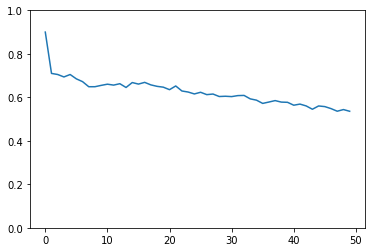

In [18]:
plt.plot(test_accuracies)
plt.ylim(ymin=0, ymax=1)
plt.show()

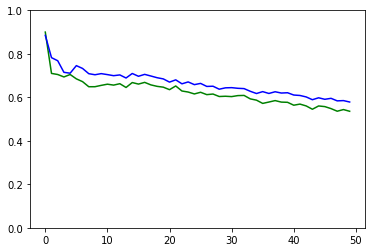

In [20]:
%store -r DB1_test_accuracies
plt.plot(test_accuracies, color='g')
plt.plot(DB1_test_accuracies, color='b')
plt.ylim(ymin=0, ymax=1)
plt.show()

(array([1.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 4.000e+00, 1.000e+01,
        1.700e+01, 2.100e+01, 2.400e+01, 5.300e+01, 7.200e+01, 9.200e+01,
        1.150e+02, 1.350e+02, 1.850e+02, 1.990e+02, 2.960e+02, 3.000e+02,
        3.650e+02, 4.660e+02, 5.140e+02, 6.330e+02, 6.390e+02, 7.130e+02,
        6.560e+02, 7.470e+02, 7.910e+02, 8.220e+02, 8.620e+02, 9.360e+02,
        9.680e+02, 1.013e+03, 1.120e+03, 1.180e+03, 1.274e+03, 1.294e+03,
        1.311e+03, 1.364e+03, 1.388e+03, 1.438e+03, 1.416e+03, 1.386e+03,
        1.414e+03, 1.301e+03, 1.359e+03, 1.316e+03, 1.283e+03, 1.178e+03,
        1.181e+03, 1.131e+03, 1.150e+03, 1.105e+03, 1.121e+03, 1.009e+03,
        1.004e+03, 9.930e+02, 9.320e+02, 8.070e+02, 7.790e+02, 6.650e+02,
        5.880e+02, 4.770e+02, 4.190e+02, 3.260e+02, 2.190e+02, 1.600e+02,
        1.300e+02, 7.400e+01, 4.400e+01, 2.900e+01, 1.000e+01, 6.000e+00,
        0.000e+00, 1.000e+00]),
 array([4.49033144e-06, 4.64078156e-06, 4.79123169e-06, 4.94168181e-06,
        

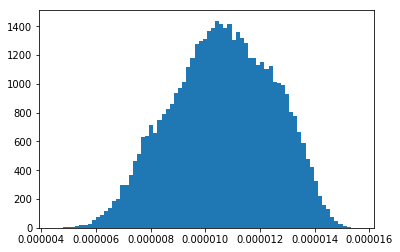

In [21]:
plt.hist(tuner.appended_task_list[-1].train.weights[0 : tuner.appended_task_list[-2].train.weights.shape[0]], bins='auto')

In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()